# Instanciação de Parâmetros

In [1]:
import pyomo as pyo

# Número de meses
T = 36

# Parâmetros
a = 60  # Constante da demanda
b = 1/2000    # Elasticidade da demanda
variable_cost_percentage = 0.25  # Percentual de custos variáveis - Depois será utilizado no problema de otimização estocástica
variable_expenses_percentage = 0.1  # Percentual de custos variáveis
taxes_percentage = 0.1  # Percentual de impostos sobre vendas, neste caso consideramos uma empresa que opera em lucro presumido
CF = 10000    # Custo fixo mensal
DF = 10000    # Despesa fixa mensal
theta_AR = 1.5
theta_I = 1
theta_AP = 1

# Intervalos de preço e quantidade
P_min = 50
P_max = 50
Q_min = 3000
Q_max = 50000

# Variação inicial da NCG (exemplo)
initial_NCG = 50 * 10000 - 247500
initial_inventory = 50000

# Meses usados no cálculo do FCO futuro
months_future_FCO = 12

# Taxa de Incremento do Lucro
profit_increment_rate = 0.7 #0.7
growth_rate = 1.3 #1.3

# Value at risk
alpha_var = 0.05
epsilon_var = 10000  # Valor inicial, será atualizado no loop

# Taxa de Desconto
GAMMA = 0.01

# Modelo Determinístico

In [2]:
from pyomo.environ import *

# Cria um modelo concreto
naive_model = model = ConcreteModel()

# Períodos
T = 36

# Variáveis de decisão
model.P = Var(range(1, T+1), bounds=(P_min, P_max))
model.Q = Var(range(1, T+1), bounds=(Q_min, Q_max), within=NonNegativeReals)

# Parâmetros de custos, despesas e impostos

initialize_variable_costs=[variable_cost_percentage*1.015**t for t in range(1, T+1)]

model.variable_cost_percentage = Param(range(1, T+1), initialize=lambda model, t: initialize_variable_costs[t-1], mutable=True)
model.variable_expenses_percentage = Param(initialize=variable_expenses_percentage)
model.taxes_percentage = Param(initialize=taxes_percentage)
model.fix_costs = Param(initialize=CF)
model.fix_expenses = Param(initialize=DF)

# Parâmetros de elasticidade da demanda
model.a = Param(initialize=a)
model.b = Param(initialize=b)

# Parâmetro de quantidade inicial de vendas
model.initial_quantity = Param(initialize=3000)
model.Q[1].fix(model.initial_quantity)

# Parâmetros de NCG
model.theta_AR = Param(initialize=theta_AR)
model.theta_I = Param(initialize=theta_I)
model.theta_AP = Param(initialize=theta_AP)
model.initial_NCG = Param(initialize=initial_NCG)
model.initial_investment = Param(initialize=initial_inventory)

# Expressões Auxiliares Gerais
def revenue_rule(model, t):
    return model.P[t] * model.Q[t]

# Expressões Auxiliares para cálculo da NCG

def AR_rule(model, t):
    # return 0
    return revenue_rule(model, t) * model.theta_AR

def I_rule(model, t):
    # return 0
    return (model.variable_cost_percentage[t] * revenue_rule(model, t)) * model.theta_I

#TODO: Adicionar o I aqui
def AP_rule(model, t):
    i_t_minus_1 = I_rule(model, t-1) if t > 1 else model.initial_investment
    return (I_rule(model, t) + model.variable_expenses_percentage * revenue_rule(model, t) -i_t_minus_1) * model.theta_AP

def NCG_rule(model, t):
    # return AR_rule(model, t) + I_rule(model, t) - AP_rule(model, t) - (AR_rule(model, t-1) + I_rule(model, t-1) - AP_rule(model, t-1) if t > 1 else model.initial_NCG)
    if t > 1:
        return AR_rule(model, t) + I_rule(model, t) - AP_rule(model, t) - (AR_rule(model, t-1) + I_rule(model, t-1) - AP_rule(model, t-1) if t > 1 else model.initial_NCG)
    else:
        return AR_rule(model, t) + I_rule(model, t) - AP_rule(model, t) - model.initial_NCG

def objective_rule(model):
    t_final = T
    return sum(revenue_rule(model, t_period) -\
        model.variable_cost_percentage[t_period] * revenue_rule(model, t_period) - \
        model.variable_expenses_percentage * revenue_rule(model, t_period) - \
        model.taxes_percentage * revenue_rule(model, t_period) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, t_period) for t_period in range(t_final-months_future_FCO+1, t_final+1))

model.objective = Objective(rule=objective_rule, sense=maximize)

# Restrição de demanda
def demand_rule(model, t):
    return model.P[t] == model.a - model.b * model.Q[t]

# model.demand = Constraint(range(1, T+1), rule=demand_rule)

def fco_rule(model, t):
    return (revenue_rule(model, t) -\
        model.variable_cost_percentage[t] * revenue_rule(model, t) - \
        model.variable_expenses_percentage * revenue_rule(model, t) - \
        model.taxes_percentage * revenue_rule(model, t) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, t)) >= 0

model.fco = Constraint(range(1, T+1), rule=fco_rule)

# Restrição de quantidade poder crescer unicamente 10% em cada mês
def growth_rule(model, t):
    return model.Q[t] <= model.Q[t-1] * 1.1 if t > 1 else model.Q[t] <= model.initial_quantity

model.growth = Constraint(range(1, T+1), rule=growth_rule)

# Restrição de o lucro ser maior ou igual ao mês anterior
def profit_rule(model, t):
    if t <= 2:
        # return pyomo true
        return revenue_rule(model, t) <= 10e10
    
    return (revenue_rule(model, t) -\
        model.variable_cost_percentage[t] * revenue_rule(model, t) - \
        model.variable_expenses_percentage * revenue_rule(model, t) - \
        model.taxes_percentage * revenue_rule(model, t) - \
        model.fix_costs - model.fix_expenses) >= ((revenue_rule(model, t-1) -\
        model.variable_cost_percentage[t-1] * revenue_rule(model, t-1) - \
        model.variable_expenses_percentage * revenue_rule(model, t-1) - \
        model.taxes_percentage * revenue_rule(model, t-1) - \
        model.fix_costs - model.fix_expenses) * profit_increment_rate)

model.profit = Constraint(range(1, T+1), rule=profit_rule)

# Componentes da NCG
model.AR = Expression(range(1, T+1), rule=AR_rule)
model.I = Expression(range(1, T+1), rule=I_rule)
model.AP = Expression(range(1, T+1), rule=AP_rule)
model.NCG = Expression(range(1, T+1), rule=NCG_rule)

# Resolver o modelo
solver = SolverFactory('gurobi')
# solver.options['NonConvex'] = 2
result = solver.solve(model, tee=True)

# Exibir os resultados
for t in range(1, T+1):
    print(f'Mês {t}: Preço = {model.P[t].value}, Quantidade = {model.Q[t].value}')
    # print(f'Mês {t}: Preço = {model.P[t].value}, Quantidade = {model.Q[t].value}, AR = {model.AR[t].value}, Estoque = {model.I[t].value}, AP = {model.AP[t].value}')

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-13
Read LP format model from file /var/folders/6n/ffgn982n58v3d24kq1527mc80000gn/T/tmprza4gdt1.pyomo.lp
Reading time = 0.00 seconds
x1: 38 rows, 72 columns, 71 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 38 rows, 72 columns and 71 nonzeros
Model fingerprint: 0x617c66bc
Model has 14 quadratic objective terms
Model has 70 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  QMatrix range    [3e-01, 1e+00]
  QLMatrix range   [8e+02, 3e+03]
  Objective range  [2e+05, 2e+05]
  QObjective range [8e-02, 3e+00]
  Bounds range     [1e+00, 5e+04]
  RHS range        [3e+03, 1e+11]
  QRHS range       [6e+03, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve rem

## Criação de Funções auxiliares para calcular Receita, Lucro e FCO

In [3]:
from pyomo.environ import value


def fco_period(model, t):
    return value(model.P[t] * model.Q[t] - model.variable_cost_percentage[t] * model.P[t] * model.Q[t] - model.variable_expenses_percentage * model.P[t] * model.Q[t] - model.taxes_percentage * model.P[t] * model.Q[t] - model.fix_costs - model.fix_expenses - model.NCG[t])

def revenue_period(model, t):
    return value(model.P[t] * model.Q[t])

def profit_period(model, t):
    return value(model.P[t] * model.Q[t] - model.variable_cost_percentage[t] * model.P[t] * model.Q[t] - model.variable_expenses_percentage * model.P[t] * model.Q[t] - model.taxes_percentage * model.P[t] * model.Q[t] - model.fix_costs - model.fix_expenses)

In [4]:
# Verificar se o modelo foi solucionado com sucesso
if result.solver.termination_condition == TerminationCondition.optimal:
    for t in range(1, T+1):
        # Calcula e exibe as componentes diretamente sem usar as expressões model.AR, model.I, model.AP, model.NCG
        AR_value = AR_rule(model, t)()
        I_value = I_rule(model, t)()
        AP_value = AP_rule(model, t)()
        NCG_value = NCG_rule(model, t)()
        revenue_value = revenue_rule(model, t)()

        print(f'Mês {t}: Preço = {model.P[t].value}, Quantidade = {model.Q[t].value}')
        print(f'  AR = {AR_value}, Estoque (I) = {I_value}, AP = {AP_value}, NCG = {NCG_value}')
        print(f'  NCG = AR - I - AP = {AR_value} - {I_value} - {AP_value} = {NCG_value}')
        # agora o lucro
        # print(f'  Lucro = {revenue_value - model.variable_cost_percentage * revenue_value - model.variable_expenses_percentage * revenue_value - model.taxes_percentage * revenue_value - model.fix_costs - model.fix_expenses}')
else:
    print("O modelo não encontrou uma solução ótima.")

Mês 1: Preço = 50.0, Quantidade = 3000
  AR = 225000.0, Estoque (I) = 38062.49999999999, AP = 3062.4999999999927, NCG = 7500.0
  NCG = AR - I - AP = 225000.0 - 38062.49999999999 - 3062.4999999999927 = 7500.0
Mês 2: Preço = 50.0, Quantidade = 3300.0000000000005
  AR = 247500.00000000006, Estoque (I) = 42496.78124999999, AP = 20934.281250000004, NCG = 9062.500000000047
  NCG = AR - I - AP = 247500.00000000006 - 42496.78124999999 - 20934.281250000004 = 9062.500000000047
Mês 3: Preço = 50.0, Quantidade = 3629.999999999916
  AR = 272249.99999999366, Estoque (I) = 47447.65626562388, AP = 23100.875015623467, NCG = 27534.281249994012
  NCG = AR - I - AP = 272249.99999999366 - 47447.65626562388 - 23100.875015623467 = 27534.281249994012
Mês 4: Preço = 50.0, Quantidade = 3992.9999999999495
  AR = 299474.9999999962, Estoque (I) = 52975.30822056963, AP = 25492.651954945493, NCG = 30360.875015626287
  NCG = AR - I - AP = 299474.9999999962 - 52975.30822056963 - 25492.651954945493 = 30360.875015626287

## Gráficos de Comportamento da Solução

### Quantidade de Vendas por Período

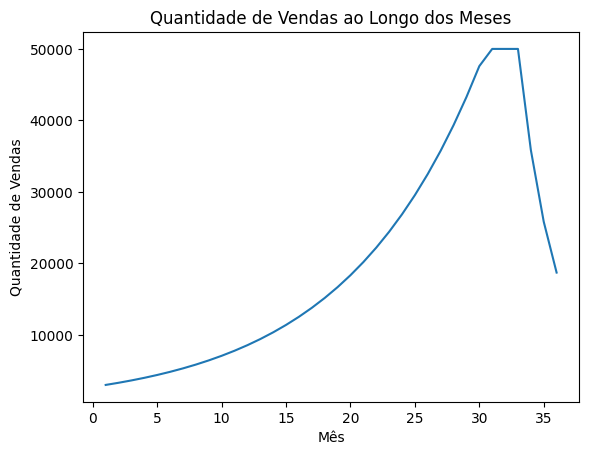

In [5]:
import matplotlib.pyplot as plt

plt.plot(range(1, T+1), [model.Q[t].value for t in range(1, T+1)])
plt.xlabel('Mês')
plt.ylabel('Quantidade de Vendas')
plt.title('Quantidade de Vendas ao Longo dos Meses')
plt.show()

### Receita por Período

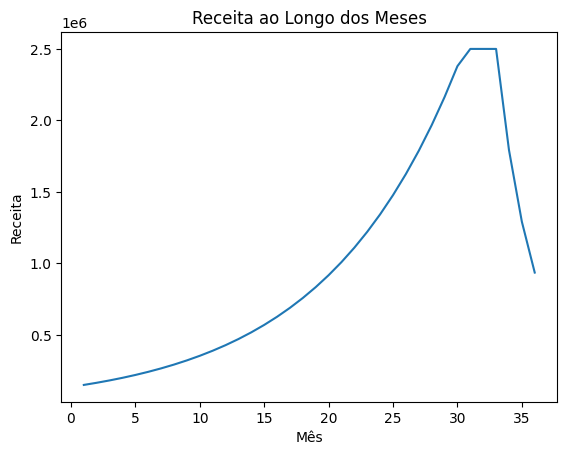

In [6]:
plt.plot(range(1, T+1), [revenue_period(model, t) for t in range(1, T+1)])
plt.xlabel('Mês')
plt.ylabel('Receita')
plt.title('Receita ao Longo dos Meses')
plt.show()

### Lucro por Período

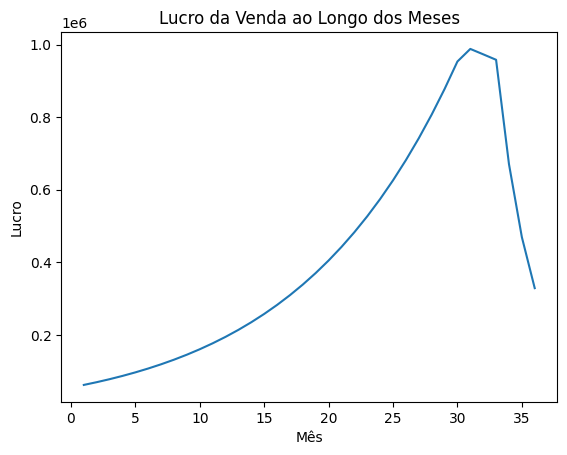

In [7]:
plt.plot(range(1, T+1), [profit_period(model, t) for t in range(1, T+1)])
plt.xlabel('Mês')
plt.ylabel('Lucro')
plt.title('Lucro da Venda ao Longo dos Meses')
plt.show()

### Fluxo de Caixa Operacional por Período

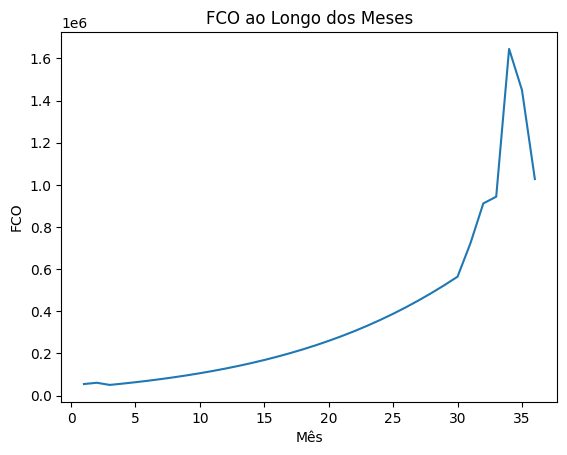

In [8]:
plt.plot(range(1, T+1), [fco_period(model, t) for t in range(1, T+1)])
plt.xlabel('Mês')
plt.ylabel('FCO')
plt.title('FCO ao Longo dos Meses')
plt.show()

# Descobrindo possíveis variações no valor de custos variáveis com base na variação do dólar

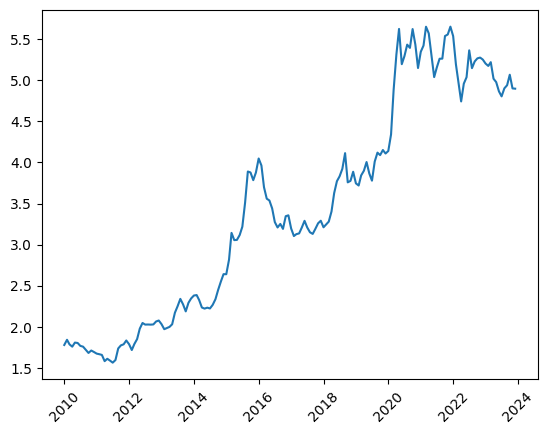

In [9]:
from currency_converter import CurrencyConverter
from datetime import datetime
from numpy import mean
import calendar
import matplotlib.pyplot as plt

c = CurrencyConverter(fallback_on_missing_rate=True)

# Pega a média do dólar mensal desde 2010
dolar_mean = []
for i in range(2010, 2024):
    for j in range(1, 13):
        _, num_days = calendar.monthrange(i, j)
        dolar_mean.append(mean([c.convert(1, 'USD', 'BRL', date=datetime(i, j, k)) for k in range(1, num_days+1)]))

# Plota o gráfico utilizando datas no eixo x
plt.plot([datetime(i, j, 1) for i in range(2010, 2024) for j in range(1, 13)], dolar_mean)
plt.xticks(rotation=45)
plt.show()


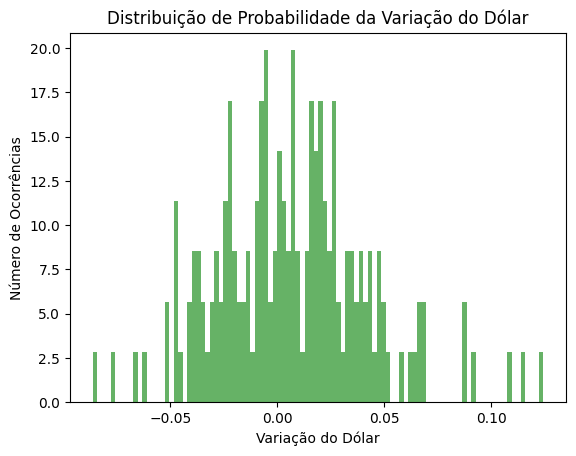

In [10]:
# Distribuição de probabilidades da variação do dólar baseado na série temporal dolar_mean
from scipy.stats import norm
import numpy as np

dolar_mean_variation = np.diff(dolar_mean)

#  Agora uma lista que pega o calor do dolar e soma com a variação
dolar_mean_variation = [(dolar_mean[i] + dolar_mean_variation[i])/dolar_mean[i] - 1 for i in range(len(dolar_mean_variation))]

# plot the histogram
plt.hist(dolar_mean_variation, bins=100, density=True, alpha=0.6, color='g')
plt.xlabel('Variação do Dólar')
plt.ylabel('Número de Ocorrências')
plt.title('Distribuição de Probabilidade da Variação do Dólar')
plt.show()


In [11]:
# Extrair os parâmetros dos dados
target_mean = np.mean(dolar_mean_variation)
target_variance = np.var(dolar_mean_variation)
target_skewness = np.mean((dolar_mean_variation - target_mean)**3) / target_variance**(3/2)
target_kurtosis = np.mean((dolar_mean_variation - target_mean)**4) / target_variance**2


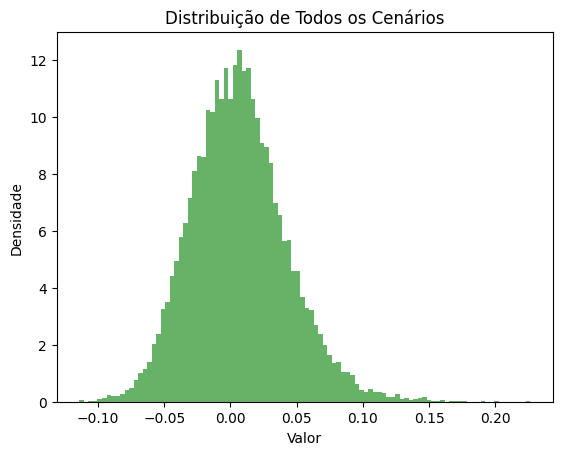

In [12]:
# Baseado no https://bjerring.github.io/equity/2019/12/12/Scenario-Generation-and-Moment-Matching.html

import numpy as np
from scipy.stats import skew, kurtosis
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def moment_matching_func(x, *args):
    """Função de ajuste de momentos que minimiza o erro entre os cenários gerados e os momentos-alvo."""
    para_match = args[0]
    exp_mu, exp_sds, exp_skew, exp_kur, exp_cov_m = para_match

    # Calcula a matriz de correlação a partir da covariância
    std_ = np.sqrt(np.diag(exp_cov_m)) if exp_cov_m.ndim > 1 else np.sqrt(exp_cov_m)
    exp_cor_m = exp_cov_m / np.outer(std_, std_) if exp_cov_m.ndim > 1 else 1.0

    # Reshape dos cenários gerados
    xx = np.reshape(x, (-1, len(exp_mu)))

    # Calcula os momentos dos cenários
    m1 = np.mean(xx, axis=0)
    m2 = np.std(xx, axis=0)
    m3 = [skew(xx[:, i]) for i in range(len(exp_mu))]
    m4 = [kurtosis(xx[:, i]) for i in range(len(exp_mu))]

    # Calcula o erro como a soma dos quadrados das diferenças
    epsilon = (np.sum((m1 - exp_mu)**2) +
               np.sum((m2 - exp_sds)**2) +
               np.sum((m3 - exp_skew)**2) +
               np.sum((m4 - exp_kur)**2) +
               np.sum((np.corrcoef(xx, rowvar=False) - exp_cor_m)**2))

    return epsilon

def generate_scenarios_with_moment_matching(mu, sigma, skewness, kurtosis, covariance, size=10000):
    """
    Gera cenários ajustando os momentos estatísticos fornecidos.
    """
    # Define os momentos-alvo
    para_match = (mu, sigma, skewness, kurtosis, covariance)

    # Verifica se a covariância é escalar (para uma variável)
    if covariance.ndim == 1:
        covariance = np.array([[covariance[0]]])  # Torna a matriz 2D para compatibilidade

    # Inicializa os cenários com uma distribuição normal multivariada
    x_ini = np.random.multivariate_normal(mu, covariance, size).ravel()

    # Minimiza o erro entre os momentos gerados e os momentos-alvo
    res = minimize(moment_matching_func, x_ini, method='CG', args=(para_match,))

    # Retorna os cenários ajustados
    scenarios = np.reshape(res.x, (-1, len(mu)))

    return scenarios

def extract_moments_and_covariance(data):
    """
    Extrai os momentos estatísticos e a matriz de covariância dos dados fornecidos.
    """
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    skewness = skew(data, axis=0)
    kurtosis_vals = kurtosis(data, axis=0)
    covariance = np.cov(data, rowvar=False)
    
    # Se for uma variável, ajuste a covariância para ser um array
    if covariance.ndim == 0:
        covariance = np.array([[covariance]])
    
    return mu, sigma, skewness, kurtosis_vals, covariance

# Parâmetros dos cenários
scenarios = 500  # Número de cenários
initial_variable_costs = 0.15
dolar_affect_parameter = 0.1

# Substitua pelo histórico da variação do dólar
historical_data = np.array(dolar_mean_variation).reshape(-1, 1)
mu, sigma, skewness, kurtosis_vals, covariance = extract_moments_and_covariance(historical_data)

# Gera os cenários
scenarios_data = []

    # Gerando valor ajustado aos momentos
data_point = generate_scenarios_with_moment_matching(
    mu=mu, 
    sigma=sigma, 
    skewness=skewness, 
    kurtosis=kurtosis_vals, 
    covariance=covariance, 
    size=(T-1)*scenarios # Subtraio 1 pois o primeiro mês é o valor percentual inicial
)
    
scenarios_data = data_point

all_data = scenarios_data.copy()

# Visualiza os dados de todos os cenários
plt.hist(all_data, bins=100, density=True, alpha=0.6, color='g')
plt.title('Distribuição de Todos os Cenários')
plt.xlabel('Valor')
plt.ylabel('Densidade')
plt.show()

In [13]:
# # Ajuste de cenários para a variação do dólar considerando o impacto nos custos variáveis
# scenarios_data = scenarios_data.reshape(scenarios, (T-1))

# scenarios_alt = np.zeros((scenarios, T))

# for i in range(scenarios):
#     # Inserir 0.25 no início para representar o custo variável inicial, deslocando todo o restante do array para frente
#     scenarios_alt[i] = np.insert(scenarios_data[i], 0, initial_variable_costs)
#     for t in range(1, T):
#         scenarios_alt[i, t] = scenarios_alt[i, t-1] * (1 + (dolar_affect_parameter * initial_variable_costs))

# scenarios_data = scenarios_alt


In [14]:
# scenarios_alt = np.zeros((scenarios, T))

scenarios_data = all_data.reshape(scenarios, (T-1)).tolist()

values = []
dolar_affect_parameter = 0.5
for i in range(scenarios):
    values_list = [initial_variable_costs]
    for t in range(1, T):
        values_list.append(values_list[t-1] + scenarios_data[i][t-1] * dolar_affect_parameter)
    values.append(values_list)

scenarios_data = values

In [15]:
import statsmodels.sandbox.distributions.extras as extras
import scipy.interpolate as interpolate
import scipy.stats as ss
import matplotlib.pyplot as plt  
import numpy as np

def generate_normal_four_moments(mu, sigma, skew, kurt, size=10000, sd_wide=10):
   f = extras.pdf_mvsk([mu, sigma, skew, kurt])
   x = np.linspace(mu - sd_wide * sigma, mu + sd_wide * sigma, num=500)
   y = [f(i) for i in x]
   yy = np.cumsum(y) / np.sum(y)
   inv_cdf = interpolate.interp1d(yy, x, fill_value="extrapolate")
   rr = np.random.rand(size)

   return inv_cdf(rr)

2 de 3600
3 de 3600
4 de 3600
5 de 3600
6 de 3600
7 de 3600
8 de 3600
9 de 3600
10 de 3600
11 de 3600
12 de 3600
13 de 3600
14 de 3600
15 de 3600
16 de 3600
17 de 3600
18 de 3600
19 de 3600
20 de 3600
21 de 3600
22 de 3600
23 de 3600
24 de 3600
25 de 3600
26 de 3600
27 de 3600
28 de 3600
29 de 3600
30 de 3600
31 de 3600
32 de 3600
33 de 3600
34 de 3600
35 de 3600
36 de 3600
38 de 3600
39 de 3600
40 de 3600
41 de 3600
42 de 3600
43 de 3600
44 de 3600
45 de 3600
46 de 3600
47 de 3600
48 de 3600
49 de 3600
50 de 3600
51 de 3600
52 de 3600
53 de 3600
54 de 3600
55 de 3600
56 de 3600
57 de 3600
58 de 3600
59 de 3600
60 de 3600
61 de 3600
62 de 3600
63 de 3600
64 de 3600
65 de 3600
66 de 3600
67 de 3600
68 de 3600
69 de 3600
70 de 3600
71 de 3600
72 de 3600
74 de 3600
75 de 3600
76 de 3600
77 de 3600
78 de 3600
79 de 3600
80 de 3600
81 de 3600
82 de 3600
83 de 3600
84 de 3600
85 de 3600
86 de 3600
87 de 3600
88 de 3600
89 de 3600
90 de 3600
91 de 3600
92 de 3600
93 de 3600
94 de 3600
95 de 3

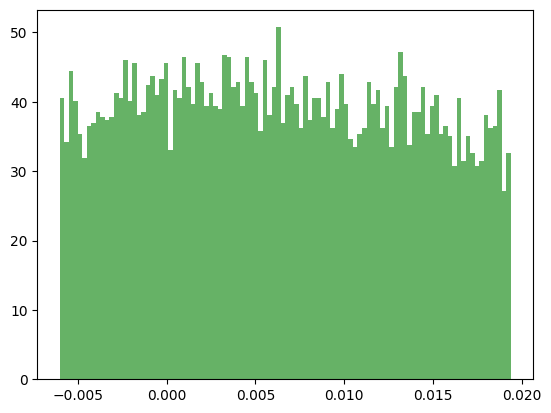

In [16]:
data = generate_normal_four_moments(mu=target_mean, sigma=target_variance, skew=target_skewness, kurt=target_kurtosis)

# plot the histogram
plt.hist(data, bins=100, density=True, alpha=0.6, color='g')

# Criando para 5 cenários
scenarios_alt = 100
scenarios_data_old = []

initial_variable_costs = 0.25
dolar_affect_parameter = 1
for i in range(scenarios_alt):
    scenario_data = []
    for j in range(1, T+1):
        if j == 1:
            scenario_data.append(initial_variable_costs)
            continue

        data = generate_normal_four_moments(mu=target_mean, sigma=target_variance, skew=target_skewness, kurt=target_kurtosis, size=1)[0]
        data = scenario_data[-1] + data * dolar_affect_parameter
        scenario_data.append(data)
        print(f'{i*T+j} de {scenarios_alt*T}')
    
    scenarios_data_old.append(scenario_data)

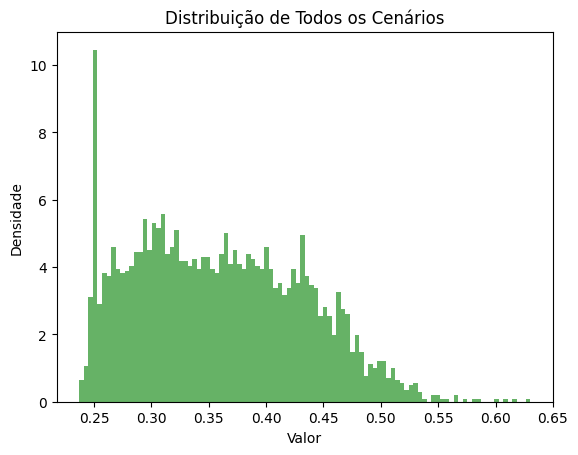

In [17]:
# Visualiza os dados de todos os cenários scenarios_data é uma lista de lista, desconstruímos para um array
all_data_old = np.array(scenarios_data_old).ravel()

plt.hist(all_data_old, bins=100, density=True, alpha=0.6, color='g')
plt.title('Distribuição de Todos os Cenários')
plt.xlabel('Valor')
plt.ylabel('Densidade')
plt.show()

# Modelo Múltiplo

In [18]:
from pyomo.environ import *

# Cria um modelo concreto
model = ConcreteModel()

# Períodos
T = 36

# Variáveis de decisão, agora são T * scenarios
model.P = Var(range(1, scenarios+1), range(1, T+1), bounds=(P_min, P_max))
model.Q = Var(range(1, scenarios+1), range(1, T+1), bounds=(Q_min, Q_max), within=NonNegativeReals)

# Parâmetros de custos, despesas e impostos
model.variable_expenses_percentage = Param(initialize=variable_expenses_percentage)
model.taxes_percentage = Param(initialize=taxes_percentage)
model.fix_costs = Param(initialize=CF)
model.fix_expenses = Param(initialize=DF)

# Agora variable_cost_percentage é um parâmetro que varia em cada cenário
model.variable_cost_percentage = Param(range(1, scenarios+1), range(1, T+1), initialize=lambda model, i, j: scenarios_data[i-1][j-1])

# Parâmetros de elasticidade da demanda
model.a = Param(initialize=a)
model.b = Param(initialize=b)

# Parâmetro de quantidade inicial de vendas
model.initial_quantity = Param(initialize=3000)
for i in range(1, scenarios+1):
    model.Q[i, 1].fix(model.initial_quantity)

# Parâmetros de NCG
model.theta_AR = Param(initialize=theta_AR)
model.theta_I = Param(initialize=theta_I)
model.theta_AP = Param(initialize=theta_AP)
model.initial_NCG = Param(initialize=initial_NCG)
model.initial_investment = Param(initialize=initial_inventory)

# Expressões Auxiliares Gerais
def revenue_rule(model, i, t):
    return model.P[i, t] * model.Q[i, t]

# Expressões Auxiliares para cálculo da NCG

def AR_rule(model, i, t):
    # return 0
    return revenue_rule(model, i, t) * model.theta_AR

def I_rule(model, i, t):
    # return 0
    return (model.variable_cost_percentage[i, t] * revenue_rule(model, i, t)) * model.theta_I

#TODO: Adicionar o I aqui
def AP_rule(model, i, t):
    i_t_minus_1 = I_rule(model, i, t-1) if t > 1 else model.initial_investment
    return (I_rule(model, i, t) + model.variable_expenses_percentage * revenue_rule(model, i, t) -i_t_minus_1) * model.theta_AP

def NCG_rule(model, i, t):
    # return AR_rule(model, t) + I_rule(model, t) - AP_rule(model, t) - (AR_rule(model, t-1) + I_rule(model, t-1) - AP_rule(model, t-1) if t > 1 else model.initial_NCG)
    if t > 1:
        return AR_rule(model, i, t) + I_rule(model, i, t) - AP_rule(model, i, t) - (AR_rule(model, i, t-1) + I_rule(model, i, t-1) - AP_rule(model, i, t-1) if t > 1 else model.initial_NCG)
    else:
        return AR_rule(model, i, t) + I_rule(model, i, t) - AP_rule(model, i, t) - model.initial_NCG


# Função objetivo

def objective_rule(model):
    t_final = T
    return sum(sum(revenue_rule(model, i, t_period) -\
        model.variable_cost_percentage[i, t_period] * revenue_rule(model, i, t_period) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t_period) - \
        model.taxes_percentage * revenue_rule(model, i, t_period) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t_period) for i in range(1, scenarios+1))/scenarios for t_period in range(t_final-months_future_FCO+1, t_final+1)) 

model.objective = Objective(rule=objective_rule, sense=maximize)

# Restrição de demanda
def demand_rule(model, t):
    return model.P[t] == model.a - model.b * model.Q[t]

# model.demand = Constraint(range(1, T+1), rule=demand_rule)

def fco_rule(model, i, t):
    return (revenue_rule(model, i, t) -\
        model.variable_cost_percentage[i, t] * revenue_rule(model, i, t) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t) - \
        model.taxes_percentage * revenue_rule(model, i, t) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t)) >= 0

model.fco = Constraint(range(1, scenarios+1), range(1, T+1), rule=fco_rule)

# Restrição de quantidade poder crescer unicamente 10% em cada mês
def growth_rule(model, i, t):
    return model.Q[i, t] <= model.Q[i, t-1] * growth_rate if t > 1 else model.Q[i, t] <= model.initial_quantity

model.growth = Constraint(range(1, scenarios+1), range(1, T+1), rule=growth_rule)

# Restrição de o lucro ser maior ou igual ao mês anterior
def profit_rule(model, i, t):
    if t <= 2:
        # return pyomo true
        return revenue_rule(model, i, t) <= 10e10
    
    return (revenue_rule(model, i, t) -\
        model.variable_cost_percentage[i, t] * revenue_rule(model, i, t) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t) - \
        model.taxes_percentage * revenue_rule(model, i, t) - \
        model.fix_costs - model.fix_expenses) >= ((revenue_rule(model, i, t-1) -\
        model.variable_cost_percentage[i, t-1] * revenue_rule(model, i, t-1) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t-1) - \
        model.taxes_percentage * revenue_rule(model, i, t-1) - \
        model.fix_costs - model.fix_expenses) * profit_increment_rate)

model.profit = Constraint(range(1, scenarios+1), range(1, T+1), rule=profit_rule)

# Componentes da NCG
model.AR = Expression(range(1, scenarios+1), range(1, T+1), rule=AR_rule)
model.I = Expression(range(1, scenarios+1), range(1, T+1), rule=I_rule)
model.AP = Expression(range(1, scenarios+1), range(1, T+1), rule=AP_rule)
model.NCG = Expression(range(1, scenarios+1), range(1, T+1), rule=NCG_rule)

# Resolver o modelo
solver = SolverFactory('gurobi')
# solver.options['NonConvex'] = 2
result = solver.solve(model, tee=True)

# Exibir os resultados
# for t in range(1, T+1):
    # print(f'Mês {t}: Preço = {model.P[t].value}, Quantidade = {model.Q[t].value}')
    # print(f'Mês {t}: Preço = {model.P[t].value}, Quantidade = {model.Q[t].value}, AR = {model.AR[t].value}, Estoque = {model.I[t].value}, AP = {model.AP[t].value}')

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-13
Read LP format model from file /var/folders/6n/ffgn982n58v3d24kq1527mc80000gn/T/tmpytoy88g4.pyomo.lp
Reading time = 0.17 seconds
x1: 19000 rows, 35501 columns, 35500 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 19000 rows, 35501 columns and 35500 nonzeros
Model fingerprint: 0x8e8d19c0
Model has 7000 quadratic objective terms
Model has 35000 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  QMatrix range    [1e-03, 1e+00]
  QLMatrix range   [4e+02, 4e+03]
  Objective range  [2e+05, 2e+05]
  QObjective range [7e-06, 6e-03]
  Bounds range     [1e+00, 5e+04]
  RHS range        [4e+03, 1e+11]
  QRHS range       [6e+03, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numeric

## Criação de Funções auxiliares para calcular Receita, Lucro e FCO

In [19]:
from pyomo.environ import value


def fco_period_multiple(model, i, t):
    return value(model.P[i, t] * model.Q[i, t] - model.variable_cost_percentage[i, t] * model.P[i, t] * model.Q[i, t] - model.variable_expenses_percentage * model.P[i, t] * model.Q[i, t] - model.taxes_percentage * model.P[i, t] * model.Q[i, t] - model.fix_costs - model.fix_expenses - model.NCG[i, t])

def revenue_period_multiple(model, i, t):
    return value(model.P[i, t] * model.Q[i, t])

def profit_period_multiple(model, i, t):
    return value(model.P[i, t] * model.Q[i, t] - model.variable_cost_percentage[i, t] * model.P[i, t] * model.Q[i, t] - model.variable_expenses_percentage * model.P[i, t] * model.Q[i, t] - model.taxes_percentage * model.P[i, t] * model.Q[i, t] - model.fix_costs - model.fix_expenses)

## Gráficos de Comportamento da Solução

### Quantidade de Vendas por Período

Text(0.5, 1.0, 'Quantidade de Vendas ao Longo dos Meses Para Cada Cenário')

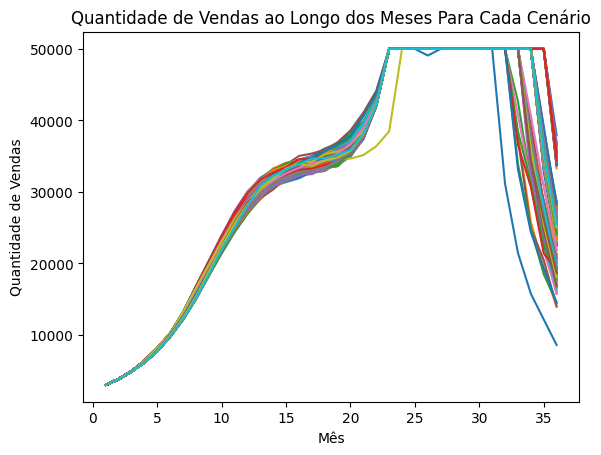

In [20]:
# plot de preço e quantidade para cada cenário
for i in range(1, scenarios+1):
    plt.plot(range(1, T+1), [model.Q[i, t].value for t in range(1, T+1)], label=f'Cenário {i}')

plt.xlabel('Mês')
plt.ylabel('Quantidade de Vendas')
plt.title('Quantidade de Vendas ao Longo dos Meses Para Cada Cenário')

### Receita por Período

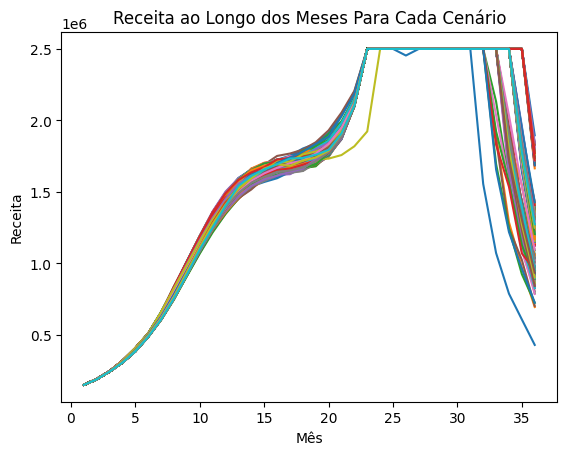

In [21]:
for i in range(1, scenarios+1):
    plt.plot(range(1, T+1), [revenue_period_multiple(model, i, t) for t in range(1, T+1)], label=f'Cenário {i}')

plt.xlabel('Mês')
plt.ylabel('Receita')
plt.title('Receita ao Longo dos Meses Para Cada Cenário')
plt.show()

### Lucro por Período

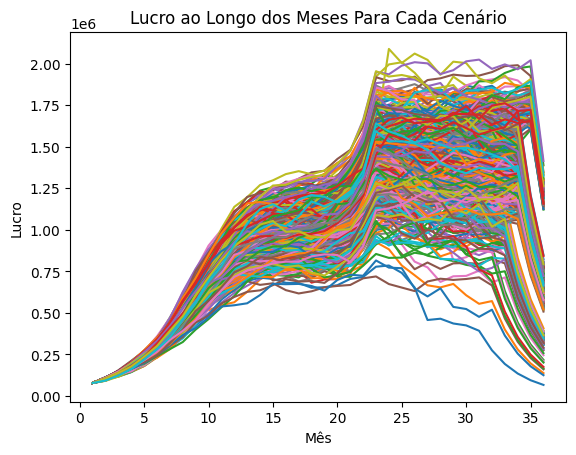

In [22]:
for i in range(1, scenarios+1):
    plt.plot(range(1, T+1), [profit_period_multiple(model, i, t) for t in range(1, T+1)], label=f'Cenário {i}')

plt.xlabel('Mês')
plt.ylabel('Lucro')
plt.title('Lucro ao Longo dos Meses Para Cada Cenário')
plt.show()

### Fluxo de Caixa Operacional por Período

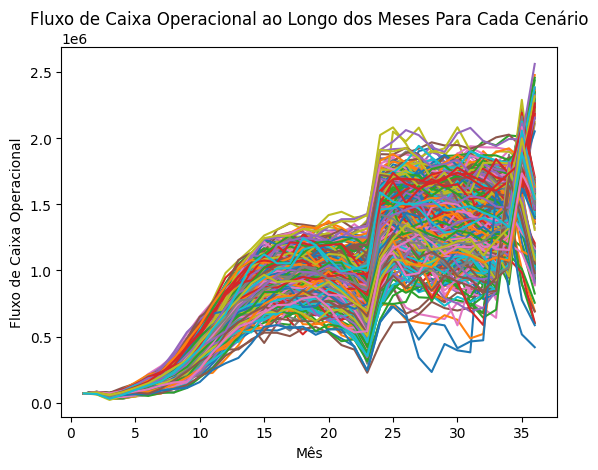

In [23]:
for i in range(1, scenarios+1):
    plt.plot(range(1, T+1), [fco_period_multiple(model, i, t) for t in range(1, T+1)], label=f'Cenário {i}')

plt.xlabel('Mês')
plt.ylabel('Fluxo de Caixa Operacional')
plt.title('Fluxo de Caixa Operacional ao Longo dos Meses Para Cada Cenário')
plt.show()

# Modelo Estocástico Mono-objetivo | FCO Último Ano

In [24]:
from pyomo.environ import *

# Cria um modelo concreto
stochastic_model = model = ConcreteModel()

# Períodos
T = 36

# Variáveis de decisão, agora são T * scenarios
model.P = Var(range(1, scenarios+1), range(1, T+1), bounds=(P_min, P_max))
model.Q = Var(range(1, T+1), bounds=(Q_min, Q_max), within=NonNegativeReals)

# Parâmetros de custos, despesas e impostos
model.variable_expenses_percentage = Param(initialize=variable_expenses_percentage)
model.taxes_percentage = Param(initialize=taxes_percentage)
model.fix_costs = Param(initialize=CF)
model.fix_expenses = Param(initialize=DF)

# Agora variable_cost_percentage é um parâmetro que varia em cada cenário
model.variable_cost_percentage = Param(range(1, scenarios+1), range(1, T+1), initialize=lambda model, i, j: scenarios_data[i-1][j-1], mutable=True)

# Parâmetros de elasticidade da demanda
model.a = Param(initialize=a)
model.b = Param(initialize=b)

# Parâmetro de quantidade inicial de vendas
model.initial_quantity = Param(initialize=3000)
model.Q[1].fix(model.initial_quantity)

# Parâmetros de NCG
model.theta_AR = Param(initialize=theta_AR)
model.theta_I = Param(initialize=theta_I)
model.theta_AP = Param(initialize=theta_AP)
model.initial_NCG = Param(initialize=initial_NCG)
model.initial_investment = Param(initialize=initial_inventory)

# Expressões Auxiliares Gerais
def revenue_rule(model, i, t):
    return model.P[i, t] * model.Q[t]

# Expressões Auxiliares para cálculo da NCG

def AR_rule(model, i, t):
    # return 0
    return revenue_rule(model, i, t) * model.theta_AR

def I_rule(model, i, t):
    # return 0
    return (model.variable_cost_percentage[i, t] * revenue_rule(model, i, t)) * model.theta_I

#TODO: Adicionar o I aqui
def AP_rule(model, i, t):
    i_t_minus_1 = I_rule(model, i, t-1) if t > 1 else model.initial_investment
    return (I_rule(model, i, t) + model.variable_expenses_percentage * revenue_rule(model, i, t) -i_t_minus_1) * model.theta_AP

def NCG_rule(model, i, t):
    # return AR_rule(model, t) + I_rule(model, t) - AP_rule(model, t) - (AR_rule(model, t-1) + I_rule(model, t-1) - AP_rule(model, t-1) if t > 1 else model.initial_NCG)
    if t > 1:
        return AR_rule(model, i, t) + I_rule(model, i, t) - AP_rule(model, i, t) - (AR_rule(model, i, t-1) + I_rule(model, i, t-1) - AP_rule(model, i, t-1) if t > 1 else model.initial_NCG)
    else:
        return AR_rule(model, i, t) + I_rule(model, i, t) - AP_rule(model, i, t) - model.initial_NCG

def objective_rule(model):
    t_final = T
    return sum(sum(revenue_rule(model, i, t_period) -\
        model.variable_cost_percentage[i, t_period] * revenue_rule(model, i, t_period) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t_period) - \
        model.taxes_percentage * revenue_rule(model, i, t_period) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t_period) for i in range(1, scenarios+1))/scenarios for t_period in range(t_final-months_future_FCO+1, t_final+1)) 

model.objective = Objective(rule=objective_rule, sense=maximize)

def other_objective_rule(model):
    gamma = GAMMA
    t_final = T
    # soma FCO_i / (1 + gamma)^t
    return sum(sum((revenue_rule(model, i, t_period) -\
        model.variable_cost_percentage[i, t_period] * revenue_rule(model, i, t_period) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t_period) - \
        model.taxes_percentage * revenue_rule(model, i, t_period) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t_period)) / (1 + gamma)**t_period for i in range(1, scenarios+1))/scenarios for t_period in range(1, t_final+1))

# Restrição de demanda
def demand_rule(model, t):
    return model.P[t] == model.a - model.b * model.Q[t]

# model.demand = Constraint(range(1, T+1), rule=demand_rule)

def fco_rule(model, i, t):
    return (revenue_rule(model, i, t) -\
        model.variable_cost_percentage[i, t] * revenue_rule(model, i, t) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t) - \
        model.taxes_percentage * revenue_rule(model, i, t) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t)) >= 0

model.fco = Constraint(range(1, scenarios+1), range(1, T+1), rule=fco_rule)

# Restrição de quantidade poder crescer unicamente 10% em cada mês
def growth_rule(model, i, t):
    return model.Q[t] <= model.Q[t-1] * growth_rate if t > 1 else model.Q[t] <= model.initial_quantity

model.growth = Constraint(range(1, scenarios+1), range(1, T+1), rule=growth_rule)

# Restrição de o lucro ser maior ou igual ao mês anterior
def profit_rule(model, i, t):
    if t <= 2:
        # return pyomo true
        return revenue_rule(model, i, t) <= 10e10
    
    return (revenue_rule(model, i, t) -\
        model.variable_cost_percentage[i, t] * revenue_rule(model, i, t) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t) - \
        model.taxes_percentage * revenue_rule(model, i, t) - \
        model.fix_costs - model.fix_expenses) >= ((revenue_rule(model, i, t-1) -\
        model.variable_cost_percentage[i, t-1] * revenue_rule(model, i, t-1) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t-1) - \
        model.taxes_percentage * revenue_rule(model, i, t-1) - \
        model.fix_costs - model.fix_expenses) * profit_increment_rate)

model.profit = Constraint(range(1, scenarios+1), range(1, T+1), rule=profit_rule)

# Componentes da NCG
model.AR = Expression(range(1, scenarios+1), range(1, T+1), rule=AR_rule)
model.I = Expression(range(1, scenarios+1), range(1, T+1), rule=I_rule)
model.AP = Expression(range(1, scenarios+1), range(1, T+1), rule=AP_rule)
model.NCG = Expression(range(1, scenarios+1), range(1, T+1), rule=NCG_rule)

# Resolver o modelo
solver = SolverFactory('gurobi')
# solver.options['NonConvex'] = 2
result = solver.solve(model, tee=True)

# Exibir os resultados
# for t in range(1, T+1):
    # print(f'Mês {t}: Preço = {model.P[t].value}, Quantidade = {model.Q[t].value}')
    # print(f'Mês {t}: Preço = {model.P[t].value}, Quantidade = {model.Q[t].value}, AR = {model.AR[t].value}, Estoque = {model.I[t].value}, AP = {model.AP[t].value}')

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-13
Read LP format model from file /var/folders/6n/ffgn982n58v3d24kq1527mc80000gn/T/tmpygcn3qkw.pyomo.lp
Reading time = 0.15 seconds
x1: 19000 rows, 18036 columns, 35500 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 19000 rows, 18036 columns and 35500 nonzeros
Model fingerprint: 0x93f82832
Model has 7000 quadratic objective terms
Model has 35000 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  QMatrix range    [1e-03, 1e+00]
  QLMatrix range   [4e+02, 4e+03]
  Objective range  [2e+05, 2e+05]
  QObjective range [7e-06, 6e-03]
  Bounds range     [1e+00, 5e+04]
  RHS range        [4e+03, 1e+11]
  QRHS range       [6e+03, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numeric

## Criação de Funções auxiliares para calcular Receita, Lucro e FCO

In [25]:
from pyomo.environ import value


def fco_period(model, i, t):
    return value(model.P[i, t] * model.Q[t] - model.variable_cost_percentage[i, t] * model.P[i, t] * model.Q[t] - model.variable_expenses_percentage * model.P[i, t] * model.Q[t] - model.taxes_percentage * model.P[i, t] * model.Q[t] - model.fix_costs - model.fix_expenses - model.NCG[i, t])

def revenue_period(model, i, t):
    return value(model.P[i, t] * model.Q[t])

def profit_period(model, i, t):
    return value(model.P[i, t] * model.Q[t] - model.variable_cost_percentage[i, t] * model.P[i, t] * model.Q[t] - model.variable_expenses_percentage * model.P[i, t] * model.Q[t] - model.taxes_percentage * model.P[i, t] * model.Q[t] - model.fix_costs - model.fix_expenses)

## Quantidade de Vendas por Período

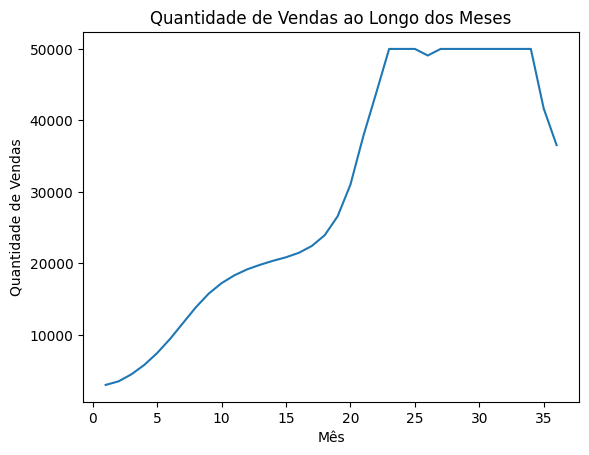

In [26]:
import matplotlib.pyplot as plt

plt.plot(range(1, T+1), [model.Q[t].value for t in range(1, T+1)])
plt.xlabel('Mês')
plt.ylabel('Quantidade de Vendas')
plt.title('Quantidade de Vendas ao Longo dos Meses')
plt.show()

## Receita por Período

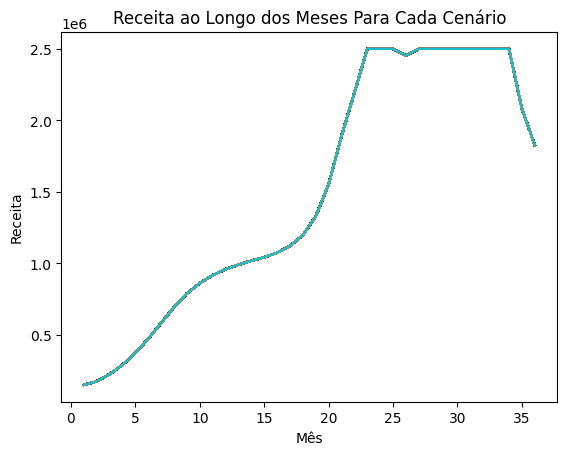

In [27]:
for i in range(1, scenarios+1):
    plt.plot(range(1, T+1), [revenue_period(model, i, t) for t in range(1, T+1)], label=f'Cenário {i}')

plt.xlabel('Mês')
plt.ylabel('Receita')
plt.title('Receita ao Longo dos Meses Para Cada Cenário')
plt.show()

## Lucro por Período

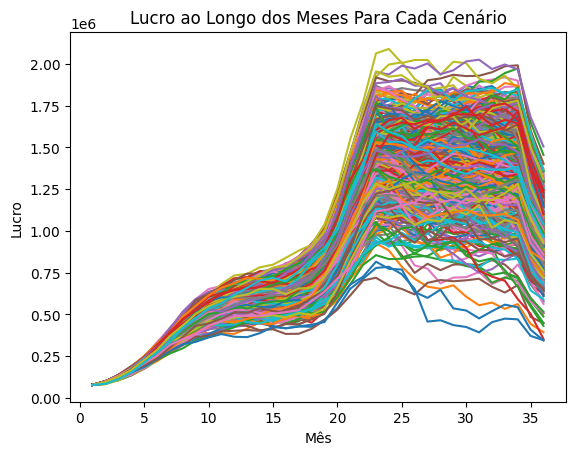

In [28]:
for i in range(1, scenarios+1):
    plt.plot(range(1, T+1), [profit_period(model, i, t) for t in range(1, T+1)], label=f'Cenário {i}')

plt.xlabel('Mês')
plt.ylabel('Lucro')
plt.title('Lucro ao Longo dos Meses Para Cada Cenário')
plt.show()

## Fluxo de Caixa Operacional por Período

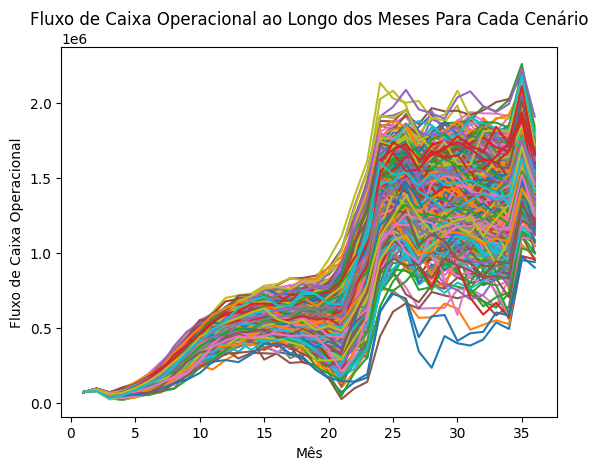

In [29]:
for i in range(1, scenarios+1):
    plt.plot(range(1, T+1), [fco_period(model, i, t) for t in range(1, T+1)], label=f'Cenário {i}')

plt.xlabel('Mês')
plt.ylabel('Fluxo de Caixa Operacional')
plt.title('Fluxo de Caixa Operacional ao Longo dos Meses Para Cada Cenário')
plt.show()

## Valores das 2 funções objetivo

In [30]:
print(f'Valor da Função Objetivo FCO: {model.objective()}')
print(f'Valor da Função NPV por GUROBI: {value(other_objective_rule(model))}')
print(f'Valor da Função NPV por Cálculo : {value(sum(sum((revenue_rule(model, i, t_period) -\
        model.variable_cost_percentage[i, t_period] * revenue_rule(model, i, t_period) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t_period) - \
        model.taxes_percentage * revenue_rule(model, i, t_period) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t_period)) / (1 + GAMMA)**t_period for i in range(1, scenarios+1))/scenarios for t_period in range(1, T+1)))}')

Valor da Função Objetivo FCO: 16772024.671092255
Valor da Função NPV por GUROBI: 21361944.765290476
Valor da Função NPV por Cálculo : 21361944.765290476


# Modelo Estocástico Mono-objetivo | Valor Presente Líquido

In [31]:
from pyomo.environ import *

# Cria um modelo concreto
stochastic_model = model = ConcreteModel()

# Períodos
T = 36

# Variáveis de decisão, agora são T * scenarios
model.P = Var(range(1, scenarios+1), range(1, T+1), bounds=(P_min, P_max))
model.Q = Var(range(1, T+1), bounds=(Q_min, Q_max), within=NonNegativeReals)

# Parâmetros de custos, despesas e impostos
model.variable_expenses_percentage = Param(initialize=variable_expenses_percentage)
model.taxes_percentage = Param(initialize=taxes_percentage)
model.fix_costs = Param(initialize=CF)
model.fix_expenses = Param(initialize=DF)

# Agora variable_cost_percentage é um parâmetro que varia em cada cenário
model.variable_cost_percentage = Param(range(1, scenarios+1), range(1, T+1), initialize=lambda model, i, j: scenarios_data[i-1][j-1], mutable=True)

# Parâmetros de elasticidade da demanda
model.a = Param(initialize=a)
model.b = Param(initialize=b)

# Parâmetro de quantidade inicial de vendas
model.initial_quantity = Param(initialize=3000)
model.Q[1].fix(model.initial_quantity)

# Parâmetros de NCG
model.theta_AR = Param(initialize=theta_AR)
model.theta_I = Param(initialize=theta_I)
model.theta_AP = Param(initialize=theta_AP)
model.initial_NCG = Param(initialize=initial_NCG)
model.initial_investment = Param(initialize=initial_inventory)

# Expressões Auxiliares Gerais
def revenue_rule(model, i, t):
    return model.P[i, t] * model.Q[t]

# Expressões Auxiliares para cálculo da NCG

def AR_rule(model, i, t):
    # return 0
    return revenue_rule(model, i, t) * model.theta_AR

def I_rule(model, i, t):
    # return 0
    return (model.variable_cost_percentage[i, t] * revenue_rule(model, i, t)) * model.theta_I

#TODO: Adicionar o I aqui
def AP_rule(model, i, t):
    i_t_minus_1 = I_rule(model, i, t-1) if t > 1 else model.initial_investment
    return (I_rule(model, i, t) + model.variable_expenses_percentage * revenue_rule(model, i, t) -i_t_minus_1) * model.theta_AP

def NCG_rule(model, i, t):
    # return AR_rule(model, t) + I_rule(model, t) - AP_rule(model, t) - (AR_rule(model, t-1) + I_rule(model, t-1) - AP_rule(model, t-1) if t > 1 else model.initial_NCG)
    if t > 1:
        return AR_rule(model, i, t) + I_rule(model, i, t) - AP_rule(model, i, t) - (AR_rule(model, i, t-1) + I_rule(model, i, t-1) - AP_rule(model, i, t-1) if t > 1 else model.initial_NCG)
    else:
        return AR_rule(model, i, t) + I_rule(model, i, t) - AP_rule(model, i, t) - model.initial_NCG

def objective_rule(model):
    gamma = GAMMA
    t_final = T
    # soma FCO_i / (1 + gamma)^t
    return sum(sum((revenue_rule(model, i, t_period) -\
        model.variable_cost_percentage[i, t_period] * revenue_rule(model, i, t_period) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t_period) - \
        model.taxes_percentage * revenue_rule(model, i, t_period) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t_period)) / (1 + gamma)**t_period for i in range(1, scenarios+1))/scenarios for t_period in range(1, t_final+1))

def other_objective_rule(model):
    t_final = T
    return sum(sum(revenue_rule(model, i, t_period) -\
        model.variable_cost_percentage[i, t_period] * revenue_rule(model, i, t_period) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t_period) - \
        model.taxes_percentage * revenue_rule(model, i, t_period) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t_period) for i in range(1, scenarios+1))/scenarios for t_period in range(t_final-months_future_FCO+1, t_final+1)) 

model.objective = Objective(rule=objective_rule, sense=maximize)

# Restrição de demanda
def demand_rule(model, t):
    return model.P[t] == model.a - model.b * model.Q[t]

# model.demand = Constraint(range(1, T+1), rule=demand_rule)

def fco_rule(model, i, t):
    return (revenue_rule(model, i, t) -\
        model.variable_cost_percentage[i, t] * revenue_rule(model, i, t) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t) - \
        model.taxes_percentage * revenue_rule(model, i, t) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t)) >= 0

model.fco = Constraint(range(1, scenarios+1), range(1, T+1), rule=fco_rule)

# Restrição de quantidade poder crescer unicamente 10% em cada mês
def growth_rule(model, i, t):
    return model.Q[t] <= model.Q[t-1] * growth_rate if t > 1 else model.Q[t] <= model.initial_quantity

model.growth = Constraint(range(1, scenarios+1), range(1, T+1), rule=growth_rule)

# Restrição de o lucro ser maior ou igual ao mês anterior
def profit_rule(model, i, t):
    if t <= 2:
        # return pyomo true
        return revenue_rule(model, i, t) <= 10e10
    
    return (revenue_rule(model, i, t) -\
        model.variable_cost_percentage[i, t] * revenue_rule(model, i, t) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t) - \
        model.taxes_percentage * revenue_rule(model, i, t) - \
        model.fix_costs - model.fix_expenses) >= ((revenue_rule(model, i, t-1) -\
        model.variable_cost_percentage[i, t-1] * revenue_rule(model, i, t-1) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t-1) - \
        model.taxes_percentage * revenue_rule(model, i, t-1) - \
        model.fix_costs - model.fix_expenses) * profit_increment_rate)

model.profit = Constraint(range(1, scenarios+1), range(1, T+1), rule=profit_rule)

# Componentes da NCG
model.AR = Expression(range(1, scenarios+1), range(1, T+1), rule=AR_rule)
model.I = Expression(range(1, scenarios+1), range(1, T+1), rule=I_rule)
model.AP = Expression(range(1, scenarios+1), range(1, T+1), rule=AP_rule)
model.NCG = Expression(range(1, scenarios+1), range(1, T+1), rule=NCG_rule)

# Resolver o modelo
solver = SolverFactory('gurobi')
# solver.options['NonConvex'] = 2
result = solver.solve(model, tee=True)

# Exibir os resultados
# for t in range(1, T+1):
    # print(f'Mês {t}: Preço = {model.P[t].value}, Quantidade = {model.Q[t].value}')
    # print(f'Mês {t}: Preço = {model.P[t].value}, Quantidade = {model.Q[t].value}, AR = {model.AR[t].value}, Estoque = {model.I[t].value}, AP = {model.AP[t].value}')

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-13
Read LP format model from file /var/folders/6n/ffgn982n58v3d24kq1527mc80000gn/T/tmpfs_6xtt8.pyomo.lp
Reading time = 0.16 seconds
x1: 19000 rows, 18036 columns, 35500 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 19000 rows, 18036 columns and 35500 nonzeros
Model fingerprint: 0x1d3725ed
Model has 17500 quadratic objective terms
Model has 35000 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  QMatrix range    [1e-03, 1e+00]
  QLMatrix range   [4e+02, 4e+03]
  Objective range  [4e+00, 4e+05]
  QObjective range [8e-06, 3e-03]
  Bounds range     [1e+00, 5e+04]
  RHS range        [4e+03, 1e+11]
  QRHS range       [6e+03, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numeri

## Quantidade de Vendas por Período

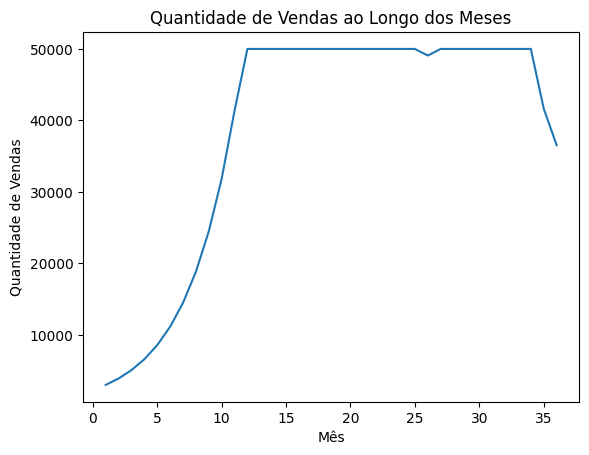

In [32]:
import matplotlib.pyplot as plt

plt.plot(range(1, T+1), [model.Q[t].value for t in range(1, T+1)])
plt.xlabel('Mês')
plt.ylabel('Quantidade de Vendas')
plt.title('Quantidade de Vendas ao Longo dos Meses')
plt.show()

## Receita por Período

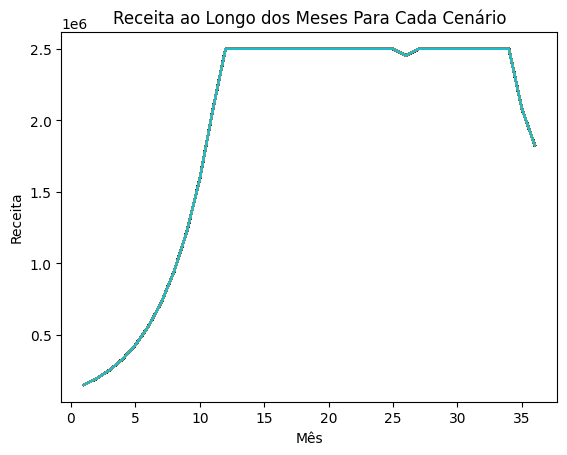

In [33]:
for i in range(1, scenarios+1):
    plt.plot(range(1, T+1), [revenue_period(model, i, t) for t in range(1, T+1)], label=f'Cenário {i}')

plt.xlabel('Mês')
plt.ylabel('Receita')
plt.title('Receita ao Longo dos Meses Para Cada Cenário')
plt.show()

## Lucro por Período

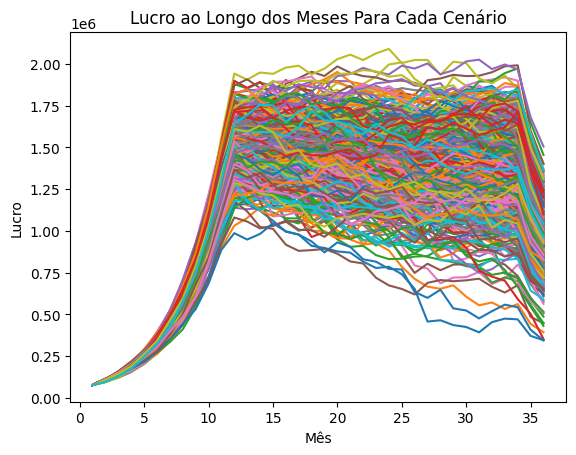

In [34]:
for i in range(1, scenarios+1):
    plt.plot(range(1, T+1), [profit_period(model, i, t) for t in range(1, T+1)], label=f'Cenário {i}')

plt.xlabel('Mês')
plt.ylabel('Lucro')
plt.title('Lucro ao Longo dos Meses Para Cada Cenário')
plt.show()

## Fluxo de Caixa Operacional por Período

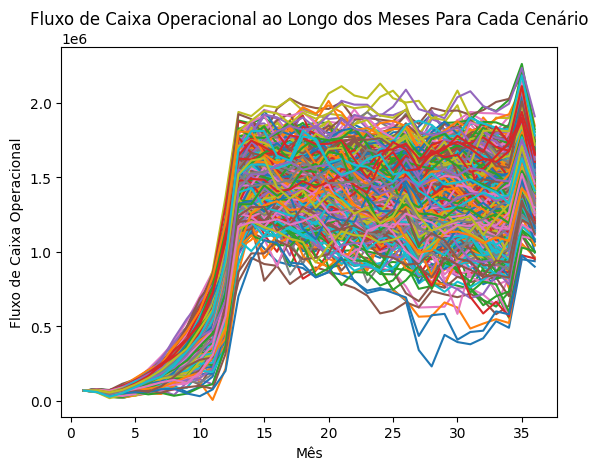

In [35]:
for i in range(1, scenarios+1):
    plt.plot(range(1, T+1), [fco_period(model, i, t) for t in range(1, T+1)], label=f'Cenário {i}')

plt.xlabel('Mês')
plt.ylabel('Fluxo de Caixa Operacional')
plt.title('Fluxo de Caixa Operacional ao Longo dos Meses Para Cada Cenário')
plt.show()

## Valores das 2 funções objetivo

In [36]:
print(f'Valor da Função Objetivo NPV: {model.objective()}')
print(f'Valor da Função FCO por GUROBI: {value(other_objective_rule(model))}')
print(f'Valor da Função FCO por Cálculo : {sum(sum(fco_period(model, i, t) for i in range(1, scenarios+1))/scenarios for t in range(1, T+1))}')

Valor da Função Objetivo NPV: 29521490.302215684
Valor da Função FCO por GUROBI: 16772024.671092216
Valor da Função FCO por Cálculo : 37072838.22419474


# Criação da Fronteira Pareto - Problema Multi-objetivo

## Utilização de método da Soma Ponderada

In [37]:
from pyomo.environ import *

# Cria um modelo concreto
stochastic_model = model = ConcreteModel()

# Períodos
T = 36
S = range(1, scenarios+1)  # Cenários

# Variáveis de decisão, agora são T * scenarios
model.P = Var(range(1, scenarios+1), range(1, T+1), bounds=(P_min, P_max))
model.Q = Var(range(1, T+1), bounds=(Q_min, Q_max), within=NonNegativeReals)

# Variáveis para CVaR
model.VarDev = Var(S, within=NonNegativeReals)  # Desvio por cenário
model.VaR = Var(within=Reals)        # Valor em Risco (VaR)
model.CVaR = Var(within=Reals)       # CVaR

# Parâmetros de custos, despesas e impostos
model.variable_expenses_percentage = Param(initialize=variable_expenses_percentage)
model.taxes_percentage = Param(initialize=taxes_percentage)
model.fix_costs = Param(initialize=CF)
model.fix_expenses = Param(initialize=DF)

# Agora variable_cost_percentage é um parâmetro que varia em cada cenário
model.variable_cost_percentage = Param(range(1, scenarios+1), range(1, T+1), initialize=lambda model, i, j: scenarios_data[i-1][j-1], mutable=True)

# Parâmetros de elasticidade da demanda
model.a = Param(initialize=a)
model.b = Param(initialize=b)

# Parâmetro de quantidade inicial de vendas
model.initial_quantity = Param(initialize=3000)
model.Q[1].fix(model.initial_quantity)

# Parâmetros de NCG
model.theta_AR = Param(initialize=theta_AR)
model.theta_I = Param(initialize=theta_I)
model.theta_AP = Param(initialize=theta_AP)
model.initial_NCG = Param(initialize=initial_NCG)
model.initial_investment = Param(initialize=initial_inventory)

# Expressões Auxiliares Gerais
def revenue_rule(model, i, t):
    return model.P[i, t] * model.Q[t]

# Expressões Auxiliares para cálculo da NCG

def AR_rule(model, i, t):
    # return 0
    return revenue_rule(model, i, t) * model.theta_AR

def I_rule(model, i, t):
    # return 0
    return (model.variable_cost_percentage[i, t] * revenue_rule(model, i, t)) * model.theta_I

#TODO: Adicionar o I aqui
def AP_rule(model, i, t):
    i_t_minus_1 = I_rule(model, i, t-1) if t > 1 else model.initial_investment
    return (I_rule(model, i, t) + model.variable_expenses_percentage * revenue_rule(model, i, t) -i_t_minus_1) * model.theta_AP

def NCG_rule(model, i, t):
    # return AR_rule(model, t) + I_rule(model, t) - AP_rule(model, t) - (AR_rule(model, t-1) + I_rule(model, t-1) - AP_rule(model, t-1) if t > 1 else model.initial_NCG)
    if t > 1:
        return AR_rule(model, i, t) + I_rule(model, i, t) - AP_rule(model, i, t) - (AR_rule(model, i, t-1) + I_rule(model, i, t-1) - AP_rule(model, i, t-1) if t > 1 else model.initial_NCG)
    else:
        return AR_rule(model, i, t) + I_rule(model, i, t) - AP_rule(model, i, t) - model.initial_NCG

def objective_rule(model):
    t_final = T
    return sum(sum(revenue_rule(model, i, t_period) -\
        model.variable_cost_percentage[i, t_period] * revenue_rule(model, i, t_period) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t_period) - \
        model.taxes_percentage * revenue_rule(model, i, t_period) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t_period) for i in range(1, scenarios+1))/scenarios for t_period in range(t_final-months_future_FCO+1, t_final+1)) 

def alternative_objective_net_present_value_rule(model):
    gamma = GAMMA
    t_final = T
    # soma FCO_i / (1 + gamma)^t
    return sum(sum((revenue_rule(model, i, t_period) -\
        model.variable_cost_percentage[i, t_period] * revenue_rule(model, i, t_period) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t_period) - \
        model.taxes_percentage * revenue_rule(model, i, t_period) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t_period)) / ((1 + gamma)**t_period) for i in range(1, scenarios+1))/scenarios for t_period in range(1, t_final+1))

# Restrição de demanda
def demand_rule(model, t):
    return model.P[t] == model.a - model.b * model.Q[t]

# model.demand = Constraint(range(1, T+1), rule=demand_rule)

def fco_rule(model, i, t):
    return (revenue_rule(model, i, t) -\
        model.variable_cost_percentage[i, t] * revenue_rule(model, i, t) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t) - \
        model.taxes_percentage * revenue_rule(model, i, t) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t)) >= 0

model.fco = Constraint(range(1, scenarios+1), range(1, T+1), rule=fco_rule)

# Restrição de quantidade poder crescer unicamente 10% em cada mês
def growth_rule(model, i, t):
    return model.Q[t] <= model.Q[t-1] * growth_rate if t > 1 else model.Q[t] <= model.initial_quantity

model.growth = Constraint(range(1, scenarios+1), range(1, T+1), rule=growth_rule)

# Restrição de o lucro ser maior ou igual ao mês anterior
def profit_rule(model, i, t):
    if t <= 2:
        # return pyomo true
        return revenue_rule(model, i, t) <= 10e10
    
    return (revenue_rule(model, i, t) -\
        model.variable_cost_percentage[i, t] * revenue_rule(model, i, t) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t) - \
        model.taxes_percentage * revenue_rule(model, i, t) - \
        model.fix_costs - model.fix_expenses) >= ((revenue_rule(model, i, t-1) -\
        model.variable_cost_percentage[i, t-1] * revenue_rule(model, i, t-1) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t-1) - \
        model.taxes_percentage * revenue_rule(model, i, t-1) - \
        model.fix_costs - model.fix_expenses) * profit_increment_rate)

model.profit = Constraint(range(1, scenarios+1), range(1, T+1), rule=profit_rule)

# Componentes da NCG
model.AR = Expression(range(1, scenarios+1), range(1, T+1), rule=AR_rule)
model.I = Expression(range(1, scenarios+1), range(1, T+1), rule=I_rule)
model.AP = Expression(range(1, scenarios+1), range(1, T+1), rule=AP_rule)
model.NCG = Expression(range(1, scenarios+1), range(1, T+1), rule=NCG_rule)

# Gerando ponto inicial e guardando
model.objective = Objective(expr=objective_rule(model), sense=maximize)
solver = SolverFactory('gurobi')
# solver.options['NonConvex'] = 2
result = solver.solve(model, tee=True)
objective_value = value(model.objective)


Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-13
Read LP format model from file /var/folders/6n/ffgn982n58v3d24kq1527mc80000gn/T/tmp4w5ymnx4.pyomo.lp
Reading time = 0.15 seconds
x1: 19000 rows, 18036 columns, 35500 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 19000 rows, 18036 columns and 35500 nonzeros
Model fingerprint: 0x93f82832
Model has 7000 quadratic objective terms
Model has 35000 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  QMatrix range    [1e-03, 1e+00]
  QLMatrix range   [4e+02, 4e+03]
  Objective range  [2e+05, 2e+05]
  QObjective range [7e-06, 6e-03]
  Bounds range     [1e+00, 5e+04]
  RHS range        [4e+03, 1e+11]
  QRHS range       [6e+03, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numeric

In [38]:
# OBJETIVO

solutions = []
pop_x = []

spaced = 20

for i, beta in enumerate(np.linspace(0.01, 0.99, spaced)):
    print(f'Iteration {i+1}/{spaced}')
    #  remove objective
    model.del_component(model.objective)
    model.objective = Objective(expr=beta*alternative_objective_net_present_value_rule(model) + (1-beta)*objective_rule(model), sense=maximize)
    solver = SolverFactory('gurobi')
    # solver.options['NonConvex'] = 2
    result = solver.solve(model, tee=True, warmstart=True)
    solutions.append((beta, value(alternative_objective_net_present_value_rule(model)), value(objective_rule(model))))

    x_sol = []

    # 1) P_{i,t}
    #    model.P[i+1, t+1] no Pyomo => lembre-se que no Pyomo o i e t começam em 1..
    for i_scenario in range(scenarios):
        for t_period in range(T):
            x_sol.append(value(model.P[i_scenario+1, t_period+1]))

    # 2) Q_t
    for t_period in range(T):
        x_sol.append(value(model.Q[t_period+1]))

    # 3) VarDev_i (se existir)
    for i_scenario in range(scenarios):
        # Se não estiver usando, pode colocar 0.0
        # ou, se estiver, use value(model.VarDev[i_scenario+1])
        x_sol.append(0.0)

    # 4) VaR e CVaR (2 vars extras)
    #    Se não estiver usando, defina 0.0 ou algo coerente
    #    Caso use, seria:
    # x_sol.append(value(model.VaR))
    # x_sol.append(value(model.CVaR))
    x_sol.append(0.0)
    x_sol.append(0.0)

    pop_x.append(x_sol)


solutions


Iteration 1/20
'pyomo.core.base.objective.ScalarObjective'>) on block unknown with a new
Component (type=<class 'pyomo.core.base.objective.ScalarObjective'>). This is
usually indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().
Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-13
Read LP format model from file /var/folders/6n/ffgn982n58v3d24kq1527mc80000gn/T/tmpyd807qwu.pyomo.lp
Reading time = 0.16 seconds
x1: 19000 rows, 18036 columns, 35500 nonzeros
Read MIP start from file /var/folders/6n/ffgn982n58v3d24kq1527mc80000gn/T/tmpksk8mr2a.gurobi.mst
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 19000 rows, 18036 columns and 35500 nonzeros
Model fingerprint: 0x32167ab3
Model has 17500 quadratic objective terms
Model has 35000 quadratic constraints
Coefficient

[(0.01, 29521490.302217722, 16772024.671091357),
 (0.06157894736842105, 29521490.302181933, 16772024.67106979),
 (0.1131578947368421, 29521490.302217294, 16772024.671087746),
 (0.16473684210526315, 29521490.30226363, 16772024.671092255),
 (0.2163157894736842, 29521490.302056413, 16772024.671089508),
 (0.26789473684210524, 29521490.302263245, 16772024.671092208),
 (0.3194736842105263, 29521490.302195422, 16772024.671089131),
 (0.37105263157894736, 29521490.30226321, 16772024.67109224),
 (0.4226315789473684, 29521490.302263685, 16772024.671092244),
 (0.47421052631578947, 29521490.30224456, 16772024.671086324),
 (0.5257894736842105, 29521490.302245278, 16772024.671081584),
 (0.5773684210526315, 29521490.302263018, 16772024.671092244),
 (0.6289473684210526, 29521490.30224186, 16772024.67109124),
 (0.6805263157894736, 29521490.302263685, 16772024.671092238),
 (0.7321052631578947, 29521490.302262887, 16772024.671092236),
 (0.7836842105263158, 29521490.302263226, 16772024.67109224),
 (0.83526

In [39]:
solutions

[(0.01, 29521490.302217722, 16772024.671091357),
 (0.06157894736842105, 29521490.302181933, 16772024.67106979),
 (0.1131578947368421, 29521490.302217294, 16772024.671087746),
 (0.16473684210526315, 29521490.30226363, 16772024.671092255),
 (0.2163157894736842, 29521490.302056413, 16772024.671089508),
 (0.26789473684210524, 29521490.302263245, 16772024.671092208),
 (0.3194736842105263, 29521490.302195422, 16772024.671089131),
 (0.37105263157894736, 29521490.30226321, 16772024.67109224),
 (0.4226315789473684, 29521490.302263685, 16772024.671092244),
 (0.47421052631578947, 29521490.30224456, 16772024.671086324),
 (0.5257894736842105, 29521490.302245278, 16772024.671081584),
 (0.5773684210526315, 29521490.302263018, 16772024.671092244),
 (0.6289473684210526, 29521490.30224186, 16772024.67109124),
 (0.6805263157894736, 29521490.302263685, 16772024.671092238),
 (0.7321052631578947, 29521490.302262887, 16772024.671092236),
 (0.7836842105263158, 29521490.302263226, 16772024.67109224),
 (0.83526

## Plotagem da Fronteira Pareto

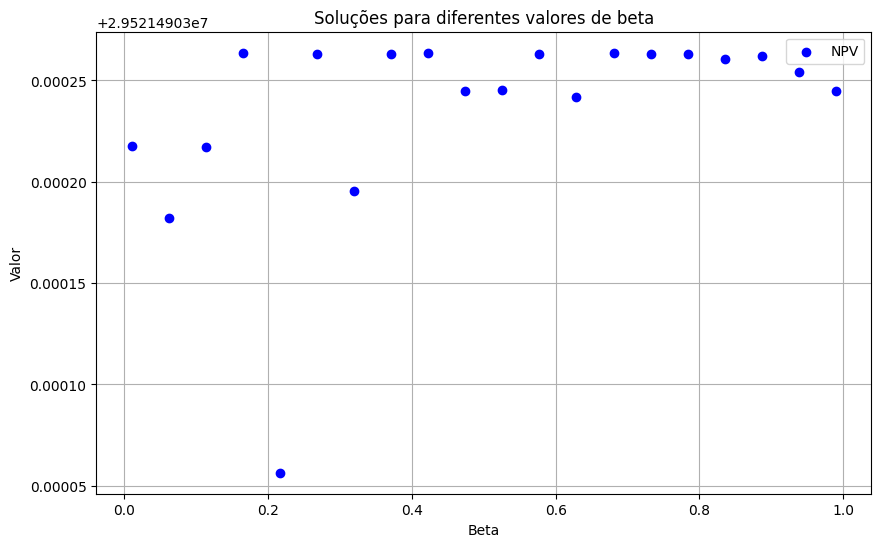

In [40]:
def plot_solutions(solutions):
    betas = [sol[0] for sol in solutions]
    NPV = [sol[1] for sol in solutions]
    FCO = [sol[2] for sol in solutions]

    plt.figure(figsize=(10, 6))
    plt.scatter(betas, NPV, label='NPV', color='blue')
    # plt.plot(betas, FCO, label='FCO', color='red')

    plt.title('Soluções para diferentes valores de beta')
    plt.xlabel('Beta')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)

    plt.show()

plot_solutions(solutions)

In [41]:
solutions

[(0.01, 29521490.302217722, 16772024.671091357),
 (0.06157894736842105, 29521490.302181933, 16772024.67106979),
 (0.1131578947368421, 29521490.302217294, 16772024.671087746),
 (0.16473684210526315, 29521490.30226363, 16772024.671092255),
 (0.2163157894736842, 29521490.302056413, 16772024.671089508),
 (0.26789473684210524, 29521490.302263245, 16772024.671092208),
 (0.3194736842105263, 29521490.302195422, 16772024.671089131),
 (0.37105263157894736, 29521490.30226321, 16772024.67109224),
 (0.4226315789473684, 29521490.302263685, 16772024.671092244),
 (0.47421052631578947, 29521490.30224456, 16772024.671086324),
 (0.5257894736842105, 29521490.302245278, 16772024.671081584),
 (0.5773684210526315, 29521490.302263018, 16772024.671092244),
 (0.6289473684210526, 29521490.30224186, 16772024.67109124),
 (0.6805263157894736, 29521490.302263685, 16772024.671092238),
 (0.7321052631578947, 29521490.302262887, 16772024.671092236),
 (0.7836842105263158, 29521490.302263226, 16772024.67109224),
 (0.83526

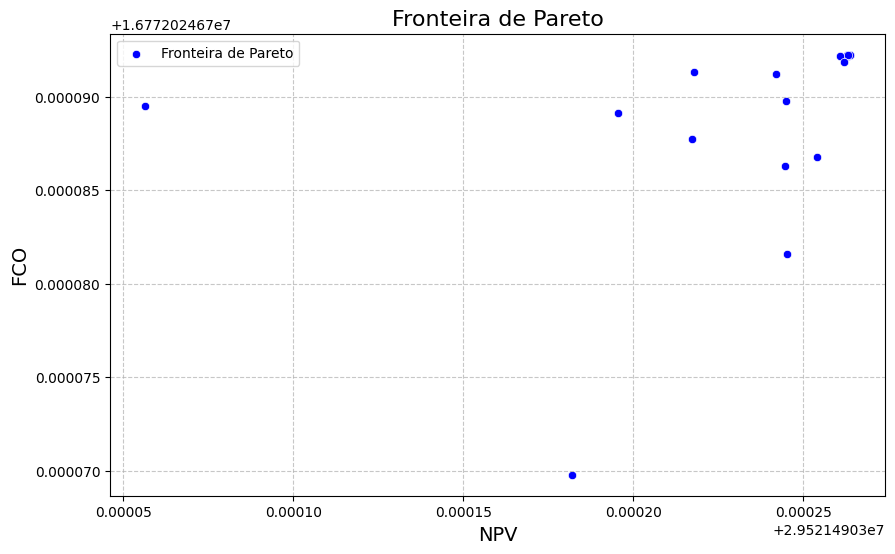

[(0.01, 29521490.302217722, 16772024.671091357),
 (0.06157894736842105, 29521490.302181933, 16772024.67106979),
 (0.1131578947368421, 29521490.302217294, 16772024.671087746),
 (0.16473684210526315, 29521490.30226363, 16772024.671092255),
 (0.2163157894736842, 29521490.302056413, 16772024.671089508),
 (0.26789473684210524, 29521490.302263245, 16772024.671092208),
 (0.3194736842105263, 29521490.302195422, 16772024.671089131),
 (0.37105263157894736, 29521490.30226321, 16772024.67109224),
 (0.4226315789473684, 29521490.302263685, 16772024.671092244),
 (0.47421052631578947, 29521490.30224456, 16772024.671086324),
 (0.5257894736842105, 29521490.302245278, 16772024.671081584),
 (0.5773684210526315, 29521490.302263018, 16772024.671092244),
 (0.6289473684210526, 29521490.30224186, 16772024.67109124),
 (0.6805263157894736, 29521490.302263685, 16772024.671092238),
 (0.7321052631578947, 29521490.302262887, 16772024.671092236),
 (0.7836842105263158, 29521490.302263226, 16772024.67109224),
 (0.83526

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_pareto(solutions):
    plt.figure(figsize=(10, 6))
    
    # Converte as soluções para um array numpy para facilitar a manipulação
    solutions = np.array(solutions)
    
    # Plota os pontos da fronteira de Pareto usando seaborn
    sns.scatterplot(x=solutions[:, 1], y=solutions[:, 2], color='blue', marker='o', label='Fronteira de Pareto')
    
    # Coloca os eixos como múltiplos de 10^6
    plt.ticklabel_format(axis='x', style='plain')
    plt.ticklabel_format(axis='y', style='plain')

    
    
    # Melhorias estéticas
    plt.xlabel('NPV', fontsize=14)
    plt.ylabel('FCO', fontsize=14)
    plt.title('Fronteira de Pareto', fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    plt.show()
    
plot_pareto(solutions)

# Imprimir minimo e máximo de cada variável

solutions

# Utilização do PyMoo

## Utilizando o NSGA-II sozinho

In [43]:
import numpy as np
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.termination import get_termination


class StochasticMultiobjectiveProblem(Problem):
    def __init__(
            self,
            scenarios, T,
            P_min, P_max,
            Q_min, Q_max,
            variable_cost_percentage,
            variable_expenses_percentage,
            taxes_percentage,
            fix_costs,
            fix_expenses,
            theta_AR, theta_I, theta_AP,
            initial_NCG,
            initial_investment,
            growth_rate,
            profit_increment_rate,
            a, b,
            initial_quantity,
            months_future_FCO,
    ):
        self.scenarios = scenarios
        self.T = T
        self.P_min = P_min
        self.P_max = P_max
        self.Q_min = Q_min
        self.Q_max = Q_max
        self.variable_cost_percentage = variable_cost_percentage
        self.variable_expenses_percentage = variable_expenses_percentage
        self.taxes_percentage = taxes_percentage
        self.fix_costs = fix_costs
        self.fix_expenses = fix_expenses
        self.theta_AR = theta_AR
        self.theta_I = theta_I
        self.theta_AP = theta_AP
        self.initial_NCG = initial_NCG
        self.initial_investment = initial_investment
        self.growth_rate = growth_rate
        self.profit_increment_rate = profit_increment_rate
        self.a = a
        self.b = b
        self.initial_quantity = initial_quantity
        self.months_future_FCO = months_future_FCO

        # Quantidade de variáveis de decisão:
        #  P_{i,t} : S*T
        #  Q_t     : T
        #  VarDev_i: S
        #  VaR, CVaR: 2
        self.nP = scenarios * T
        self.nQ = T
        self.nVarDev = scenarios
        self.nTotal = self.nP + self.nQ + self.nVarDev + 2  # + VaR + CVaR

        # Limites inferiores (xl) e superiores (xu)
        lb_P = np.full(self.nP, P_min)
        ub_P = np.full(self.nP, P_max)

        lb_Q = np.full(self.nQ, Q_min)
        ub_Q = np.full(self.nQ, Q_max)

        lb_VarDev = np.full(self.nVarDev, 0.0)   
        ub_VarDev = np.full(self.nVarDev, 1e15)  

        lb_extra = np.array([-1e15, -1e15])  # VaR, CVaR sem limite inferior real
        ub_extra = np.array([+1e15, +1e15])

        xl = np.concatenate([lb_P, lb_Q, lb_VarDev, lb_extra])
        xu = np.concatenate([ub_P, ub_Q, ub_VarDev, ub_extra])

        # --------------------------------------------------------
        # Quantas constraints ao todo?
        # --------------------------------------------------------
        # (a) fco_rule(i,t): S*T
        # (b) demand_rule(i,t): 2*S*T (igualdade => 2 ineq)
        # (c) growth_rule(i,t): S*(T-1)
        # (d) profit_rule(i,t): S*(T-2) (se T>2)
        n_fco      = self.scenarios * self.T
        n_demand   = 2 * self.scenarios * self.T
        n_demand = 0
        n_growth   = self.scenarios * max(0, (self.T - 1))
        n_profit   = self.scenarios * max(0, (self.T - 2))
        n_constr   = n_fco + n_demand + n_growth + n_profit

        super().__init__(
            n_var=self.nTotal,
            n_obj=2,         # -objective_rule e CVaR
            n_constr=n_constr,
            xl=xl,
            xu=xu
        )

    # ----------------
    # Índices
    # ----------------
    def _index_p(self, i, t):
        return i*self.T + t

    def _index_q(self, t):
        return self.nP + t

    def _index_vardev(self, i):
        return self.nP + self.nQ + i

    def _index_var(self):
        return self.nP + self.nQ + self.nVarDev

    def _index_cvar(self):
        return self.nP + self.nQ + self.nVarDev + 1

    # ----------------
    # Auxiliares
    # ----------------
    def revenue_rule(self, P_it, Q_t):
        return P_it * Q_t

    def AR_rule(self, P_it, Q_t):
        return self.revenue_rule(P_it, Q_t) * self.theta_AR

    def I_rule(self, i, t, P_it, Q_t):
        return (self.variable_cost_percentage[i, t] * self.revenue_rule(P_it, Q_t)) * self.theta_I

    def AP_rule(self, i, t, P_it, Q_t, I_t, I_t_minus_1):
        return (I_t + self.variable_expenses_percentage * self.revenue_rule(P_it, Q_t) - I_t_minus_1) * self.theta_AP

    def NCG_rule(self, i, t, x):
        idx_pit = self._index_p(i, t)
        P_it = x[idx_pit]
        idx_qt = self._index_q(t)
        Q_t = x[idx_qt]

        AR_t = self.AR_rule(P_it, Q_t)
        I_t = self.I_rule(i, t, P_it, Q_t)

        if t == 0:
            I_t_minus_1 = self.initial_investment
        else:
            idx_p_i_t_1 = self._index_p(i, t-1)
            P_i_t_1 = x[idx_p_i_t_1]
            idx_q_t_1 = self._index_q(t-1)
            Q_t_1 = x[idx_q_t_1]
            I_t_minus_1 = self.I_rule(i, t-1, P_i_t_1, Q_t_1)

        AP_t = self.AP_rule(i, t, P_it, Q_t, I_t, I_t_minus_1)
        current = AR_t + I_t - AP_t

        if t == 0:
            previous = self.initial_NCG
        else:
            # AR(t-1) + I(t-1) - AP(t-1)
            idx_p_i_t_1 = self._index_p(i, t-1)
            P_i_t_1 = x[idx_p_i_t_1]
            idx_q_t_1 = self._index_q(t-1)
            Q_t_1 = x[idx_q_t_1]
            AR_t_1 = self.AR_rule(P_i_t_1, Q_t_1)
            I_t_1 = self.I_rule(i, t-1, P_i_t_1, Q_t_1)

            if (t-1) == 0:
                AP_t_1 = self.AP_rule(i, 0, P_i_t_1, Q_t_1, I_t_1, self.initial_investment)
            else:
                idx_p_i_t_2 = self._index_p(i, t-2)
                P_i_t_2 = x[idx_p_i_t_2]
                idx_q_t_2 = self._index_q(t-2)
                Q_t_2 = x[idx_q_t_2]
                I_t_2 = self.I_rule(i, t-2, P_i_t_2, Q_t_2)
                AP_t_1 = self.AP_rule(i, t-1, P_i_t_1, Q_t_1, I_t_1, I_t_2)

            previous = AR_t_1 + I_t_1 - AP_t_1

        return current - previous

    def monthly_profit(self, i, t, x):
        idx_pit = self._index_p(i, t)
        P_it = x[idx_pit]
        idx_qt = self._index_q(t)
        Q_t = x[idx_qt]
        rev = self.revenue_rule(P_it, Q_t)
        return (
            rev
            - self.variable_cost_percentage[i, t] * rev
            - self.variable_expenses_percentage * rev
            - self.taxes_percentage * rev
            - self.fix_costs
            - self.fix_expenses
        )

    def fco_rule(self, i, t, x):
        return self.monthly_profit(i, t, x) - self.NCG_rule(i, t, x)

    def final_fco_sum(self, i, x):
        start_t = self.T - self.months_future_FCO
        total = 0.0
        for t in range(start_t, self.T):
            total += self.fco_rule(i, t, x)
        return total

    def discounted_fco_sum(self, i, x):
        start_t = 0
        total = 0.0
        for t in range(0, self.T):
            total += (self.fco_rule(i, t-1, x) / (1 + GAMMA)**t)
        return total

    def objective_rule(self, x):
        # soma final fco nos últimos meses, e faz a média
        total = 0.0
        for i in range(self.scenarios):
            total += self.final_fco_sum(i, x)
        return total / self.scenarios
    
    def alternate_objective_rule(self, x):
        # soma final fco nos últimos meses, e faz a média
        total = 0.0
        for i in range(self.scenarios):
            total += self.discounted_fco_sum(i, x)
        return total / self.scenarios


    # =======================================================================
    # AQUI: mude de "evaluate" para "_evaluate"
    # =======================================================================
    def _evaluate(self, X, out, *args, **kwargs):
        # X pode ter shape (pop_size, n_var) ou (n_var,)
        if X.ndim == 1:
            X = X[None, :]

        n_ind = X.shape[0]
        
        # Prepara saidas
        F = np.zeros((n_ind, 2))  # 2 objetivos
        G = np.zeros((n_ind, self.n_constr))  # constraints

        for k in range(n_ind):
            xk = X[k, :]

            # ------------------------
            # Objetivos
            # ------------------------
            # 1) Maximize objective_rule -> minimize -objective_rule
            obj_rule = self.objective_rule(xk)
            F[k, 0] = -obj_rule

            # 2) Minimizar CVaR
            alternative_objective_net_present_value_rule = self.alternate_objective_rule(xk)
            F[k, 1] = -alternative_objective_net_present_value_rule

            # ------------------------
            # Restrições
            # ------------------------
            # Montamos uma lista e depois jogamos em G[k,:]
            g_list = []

            eps_tol = 0

            # (a) fco_rule(i,t) >= 0 => -fco_rule(i,t) <= 0
            for i in range(self.scenarios):
                for t in range(self.T):
                    fco_it = self.fco_rule(i, t, xk)
                    g_list.append(-fco_it)  # <= 0

            # (b) demand_rule: P_{i,t} = a - b*Q_t => 2 ineq
            for i in range(self.scenarios):
                for t in range(self.T):
                    P_it = xk[self._index_p(i, t)]
                    Q_t = xk[self._index_q(t)]
                    expr = P_it - (self.a - self.b * Q_t)
                    # expr = 0 => expr <=0 and -expr <=0
                    # g_list.append(expr)      # <= 0
                    # g_list.append(-expr)     # <= 0

            # (c) growth_rule: Q[t] <= growth_rate * Q[t-1]
            #                 => Q[t] - growth_rate * Q[t-1] <= 0
            if self.T > 1:
                for i in range(self.scenarios):
                    for t in range(1, self.T):
                        Qt = xk[self._index_q(t)]
                        Qtm1 = xk[self._index_q(t-1)]
                        g_list.append(Qt - self.growth_rate * Qtm1)

            # (d) profit_rule:
            #    se t<=2 => sem restrição
            #    caso contrário => profit(i,t) >= profit(i,t-1)*rate => => -(profit(t) - profit(t-1)*rate) <=0
            #    Lembrando que t Pyomo=1..T, mas aqui t=0..T-1. Então "t<=2" em Pyomo ~ "t<=1" aqui (deslocando 1).
            for i in range(self.scenarios):
                # Precisamos checar do t=2 (Pyomo) -> t=1 (nosso 0-based)
                # Mas o seu Pyomo faz if t<=2 => sempre True => sem restrição
                # => restrição começa em t>=3 => no 0-based, t>=2
                # Então laço t=2..(T-1)
                for t in range(2, self.T):
                    profit_t = self.monthly_profit(i, t, xk)
                    profit_t_minus_1 = self.monthly_profit(i, t-1, xk)
                    g_list.append(-(profit_t - profit_t_minus_1*self.profit_increment_rate))

            G[k, :] = np.array(g_list)

        out["F"] = F
        out["G"] = G


# ================
# EXEMPLO DE USO
# ================
if __name__ == "__main__":
    # Número de meses
    T = 36

    # Parâmetros
    a = 60                  # Constante da demanda
    b = 1/2000              # Elasticidade da demanda
    variable_cost_percentage = np.array(scenarios_data) # Custo variável (se for determinístico)
    variable_expenses_percentage = 0.1
    taxes_percentage = 0.1
    CF = 10000              # Custo fixo
    DF = 10000              # Despesa fixa
    theta_AR = 1
    theta_I = 1
    theta_AP = 1

    # Intervalos de preço e quantidade
    P_min = 50
    P_max = 50
    Q_min = 3000
    Q_max = 50000

    # Variação inicial da NCG (exemplo)
    initial_NCG = 50 * 10000 - 247500
    initial_inventory = 50000

    # Meses usados no cálculo do FCO futuro
    months_future_FCO = 12

    # Taxa de incremento do lucro
    profit_increment_rate = 0.7
    growth_rate = 1.3

    # Value at Risk
    alpha_var = 0.05
    epsilon_var = 10000

    problem = StochasticMultiobjectiveProblem(
        scenarios=scenarios,
        T=T,
        P_min=P_min, P_max=P_max,
        Q_min=Q_min, Q_max=Q_max,
        variable_cost_percentage=variable_cost_percentage,
        variable_expenses_percentage=variable_expenses_percentage,
        taxes_percentage=taxes_percentage,
        fix_costs=CF,
        fix_expenses=DF,
        theta_AR=theta_AR,
        theta_I=theta_I,
        theta_AP=theta_AP,
        initial_NCG=initial_NCG,
        initial_investment=initial_inventory,
        growth_rate=growth_rate,
        profit_increment_rate=profit_increment_rate,
        a=a, b=b,
        initial_quantity=3000,
        months_future_FCO=months_future_FCO,
    )

    # Algoritmo de otimização
    algorithm = NSGA2(pop_size=50)

    # Critério de parada
    termination = get_termination("n_gen", 5)

    # Rodar otimização
    # res = minimize(problem, algorithm, termination, verbose=True)


Solução 0 é factível
Solução 1 é factível
Solução 2 é factível
Solução 3 é factível
Solução 4 é factível
Solução 5 é factível
Solução 6 é factível
Solução 7 é factível
Solução 8 é factível
Solução 9 é factível
Solução 10 é factível
Solução 11 é factível
Solução 12 é factível
Solução 13 é factível
Solução 14 é factível
Solução 15 é factível
Solução 16 é factível
Solução 17 é factível
Solução 18 é factível
Solução 19 é factível


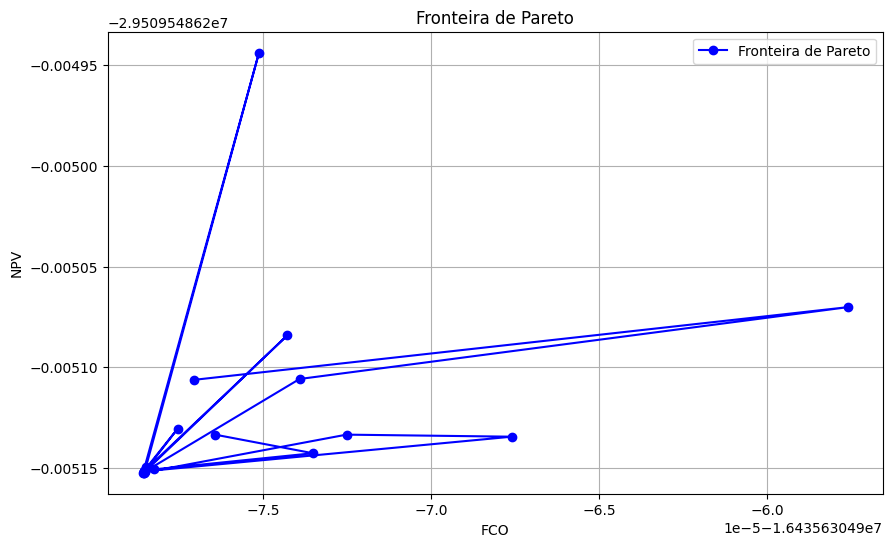

In [44]:
# Análise de Consistência

# 1) Verificar se a fronteira de Pareto é consistente com o esperado

# Pegar init_pop = np.array(pop_x) e calcular nos objetivos do problema

init_pop = np.array(pop_x)

F = np.zeros((init_pop.shape[0], 2))
G = np.zeros((init_pop.shape[0], problem.n_constr))

for k in range(init_pop.shape[0]):
    xk = init_pop[k, :]
    evaluation = problem.evaluate(xk, return_values_of=["F", "G"])
    F[k, :] = evaluation[0]  # Supondo que "F" seja o primeiro elemento da tupla
    G[k, :] = evaluation[1]  # Supondo que "G" seja o segundo elemento da tupla

# 2) Verificar se as restrições são satisfeitas

# Se G[k, :] for tudo zero, então a solução é factível
# Se G[k, :] for diferente de zero, então a solução é infactível

for k in range(init_pop.shape[0]):
    if np.all(G[k, :] < 1e-6):
        print(f"Solução {k} é factível")
    else:
        print(f"Solução {k} é infactível por conta das restrições {np.where(G[k, :] > 1e-6)}")

# 3) Verificar se a fronteira de Pareto é consistente com o esperado

plt.figure(figsize=(10, 6))
plt.plot(F[:, 0], F[:, 1], color='blue', marker='o', linestyle='-', label='Fronteira de Pareto')
plt.xlabel('FCO')
plt.ylabel('NPV')
plt.title('Fronteira de Pareto')
plt.grid(True)
plt.legend()
plt.show()

## Análise das Soluções

In [45]:
# # Plot pareto

# import matplotlib.pyplot as plt

# F = res.F

# plt.figure(figsize=(10, 6))
# plt.scatter(F[:, 0], F[:, 1], color='blue', marker='o', s=30)
# plt.xlabel('FCO')
# plt.ylabel('NPV')
# plt.title('Fronteira de Pareto')
# plt.grid(True)
# plt.show()



## Utilizando as soluções inicialmente encontradas como ponto de partida para o NSGA-II

In [50]:
T = 36

# Parâmetros
a = 60  # Constante da demanda
b = 1/2000    # Elasticidade da demanda
variable_cost_percentage = np.array(scenarios_data)  # Percentual de custos variáveis - Depois será utilizado no problema de otimização estocástica
variable_expenses_percentage = 0.1  # Percentual de custos variáveis
taxes_percentage = 0.1  # Percentual de impostos sobre vendas, neste caso consideramos uma empresa que opera em lucro presumido
CF = 10000    # Custo fixo mensal
DF = 10000    # Despesa fixa mensal
theta_AR = 1
theta_I = 1
theta_AP = 1

# Intervalos de preço e quantidade
P_min = 50
P_max = 50
Q_min = 3000
Q_max = 50000

# Variação inicial da NCG (exemplo)
initial_NCG = 50 * 10000 - 247500
initial_inventory = 50000

# Meses usados no cálculo do FCO futuro
months_future_FCO = 12

# Taxa de Incremento do Lucro
profit_increment_rate = 0.7 #0.7
growth_rate = 1.3 #1.3

# Value at risk
alpha_var = 0.05
epsilon_var = 10000  # Valor inicial, será atualizado no loop

problem = StochasticMultiobjectiveProblem(
    scenarios=scenarios,
    T=T,
    P_min=P_min, P_max=P_max,
    Q_min=Q_min, Q_max=Q_max,
    variable_cost_percentage=variable_cost_percentage,
    variable_expenses_percentage=variable_expenses_percentage,
    taxes_percentage=taxes_percentage,
    fix_costs=CF,
    fix_expenses=DF,
    theta_AR=theta_AR,
    theta_I=theta_I,
    theta_AP=theta_AP,
    initial_NCG=initial_NCG,
    initial_investment=50000,
    growth_rate=growth_rate,
    profit_increment_rate=profit_increment_rate,
    a=a, b=b,
    initial_quantity=3000,
    months_future_FCO=months_future_FCO,
)

init_pop = np.array(pop_x)  # shape = (n_solutions, n_var)

algorithm = NSGA2(
    pop_size=200,
)

termination = get_termination("n_gen", 100)

# Rodar otimização
res = minimize(problem, algorithm, termination, verbose=True)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      200 |      1 |  1.090084E+09 |  2.305166E+09 |             - |             -
     2 |      400 |      1 |  8.555959E+08 |  1.796210E+09 |             - |             -
     3 |      600 |      1 |  6.568526E+08 |  1.500395E+09 |             - |             -
     4 |      800 |      1 |  6.568526E+08 |  1.259150E+09 |             - |             -
     5 |     1000 |      1 |  4.514391E+08 |  1.035586E+09 |             - |             -
     6 |     1200 |      1 |  4.514391E+08 |  8.683103E+08 |             - |             -
     7 |     1400 |      1 |  3.271982E+08 |  7.306144E+08 |             - |             -
     8 |     1600 |      1 |  2.298590E+08 |  6.211590E+08 |             - |             -
     9 |     1800 |      1 |  1.758243E+08 |  5.322071E+08 |             - |             -
    10 |     2000 |      1 |  1.157363E+08 |  4.345060E+08 |             - |             -

KeyboardInterrupt: 

Objetivo 1: 16435630.495478567, Objetivo 2: 29509548.625151955
Objetivo 1: 16435630.495478567, Objetivo 2: 29509548.62515176
Objetivo 1: 16435630.495478548, Objetivo 2: 29509548.625151925
Objetivo 1: 16435630.495478563, Objetivo 2: 29509548.625151634
Objetivo 1: 16435630.49547844, Objetivo 2: 29509548.625151698
Objetivo 1: 16435630.495478552, Objetivo 2: 29509548.625150643
Objetivo 1: 16435630.495478515, Objetivo 2: 29509548.625151016
Objetivo 1: 16435630.49547826, Objetivo 2: 29509548.62515075
Objetivo 1: 16435630.495478498, Objetivo 2: 29509548.625149
Objetivo 1: 16435630.4954776, Objetivo 2: 29509548.625150993
Objetivo 1: 16435630.495478434, Objetivo 2: 29509548.625148706
Objetivo 1: 16435630.495477429, Objetivo 2: 29509548.62514907
Objetivo 1: 16435630.495477727, Objetivo 2: 29509548.62513783
Objetivo 1: 16435630.495477442, Objetivo 2: 29509548.6251389
Objetivo 1: 16435630.495477702, Objetivo 2: 29509548.625137836
Objetivo 1: 16435630.495474476, Objetivo 2: 29509548.625148766
Objet

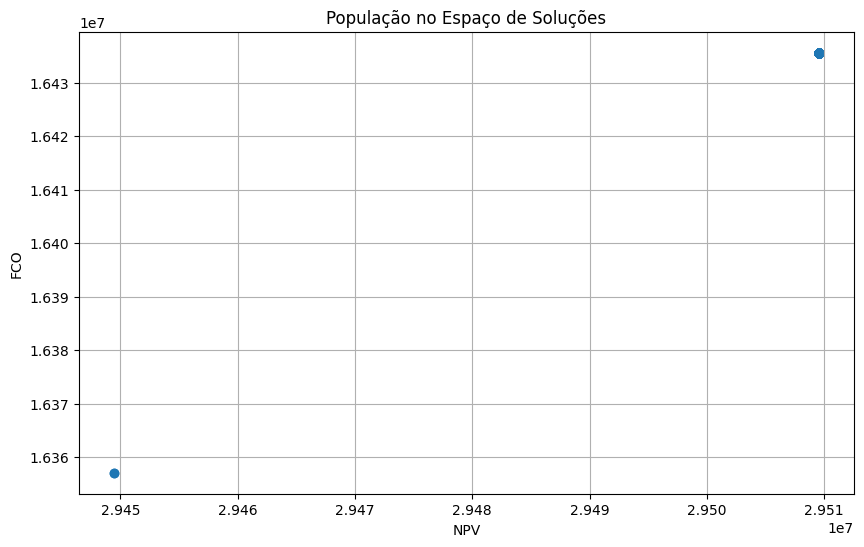

In [ ]:
# Plotar a fronteira de Pareto
# Pegar toda a população final e calcular os objetivos
F = np.zeros((res.pop.get("X").shape[0], 2))
for i, x in enumerate(res.pop.get("X")):
    F[i, 0] = problem.objective_rule(x)
    F[i, 1] = problem.alternate_objective_rule(x)

    print(f'Objetivo 1: {F[i, 0]}, Objetivo 2: {F[i, 1]}')

plt.figure(figsize=(10, 6))
plt.scatter(F[:, 1], F[:, 0])

plt.xlabel('NPV')
plt.ylabel('FCO')
plt.title('População no Espaço de Soluções')
plt.grid(True)
plt.show()

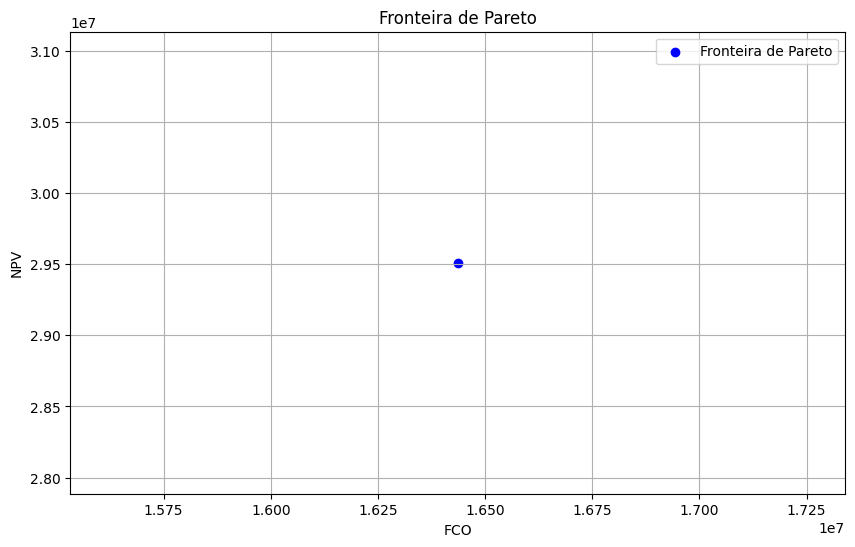

In [ ]:
F = res.F

plt.figure(figsize=(10, 6))
plt.scatter(-F[:, 0], -F[:, 1], color='blue', marker='o', label='Fronteira de Pareto')
plt.xlabel('FCO')
plt.ylabel('NPV')
plt.title('Fronteira de Pareto')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
F


array([[-16435630.49547857, -29509548.62515195]])